In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Given code for generation of one- site data

In [2]:
import numpy as np
from scipy.linalg import eigh

def get_filename(t, U, suffix):
    """
    Generate a filename like t1.000_U5.830.dat based on t and U values.
    This helps distinguish output files for different parameter settings.
    """

    return f"t{t:.3f}_U{U:.3f}{suffix}"

def initialize_operators(dimf):
    """
        Initialize the annihilation (a), creation (a†), and number (n) operators
        as matrices in a truncated Fock space of size dimf.
        
        Returns:
            aDop: creation operator matrix (a†)
            aop: annihilation operator matrix (a)
            nop: number operator matrix (n = a†a)
            Umat: identity matrix of size dimf (used for φ²·I term)
    """
    aDop = np.zeros((dimf, dimf))
    aop = np.zeros((dimf, dimf))
    nop = np.zeros((dimf, dimf))
    Umat = np.identity(dimf)
    
    for bs in range(dimf):
        for ks in range(dimf):
            if bs == ks:
                nop[bs, ks] = ks                   # Diagonal: n|k⟩ = k|k⟩
            elif bs == ks + 1:
                aDop[bs, ks] = np.sqrt(ks + 1)     # a†|k⟩ = √(k+1)|k+1⟩
            elif bs == ks - 1:
                aop[bs, ks] = np.sqrt(ks)          # a|k⟩ = √k|k-1⟩
    
    return aDop, aop, nop, Umat

def construct_hamiltonian(dimf, t, U, cpc, phi, aDop, aop, nop, Umat):
    """
    Construct the mean-field decoupled single-site Hamiltonian matrix.
    
    H = -t·φ·(a + a†) + t·φ²·I + (U/2)·n(n-1) - μ·n

     ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \     # hopping term (mean-field decoupled)
                        + t * phi**2 * Umat[i, j] \               # φ²·I shift (mean-field correction)
                        + (U / 2.0) * (nop[i, j]**2 - nop[i, j]) \# on-site interaction energy
                        - cpc * nop[i, j]                         # chemical potential term (−μ·n)
            ham[j, i] = ham[i, j]  # Matrix is Hermitian (real symmetric here)
    
    Parameters:
        dimf : basis dimension
        t, U : hopping and interaction parameters
        cpc  : chemical potential μ (called "cpc" in code)
        phi  : current guess for superfluid order parameter φ
        aDop, aop, nop, Umat : operator matrices
    
    Returns:
        ham : Hamiltonian matrix (dimf x dimf)
    """
    ham = np.zeros((dimf, dimf))
    for i in range(dimf):
        for j in range(i + 1):
            ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \
                        + t * phi**2 * Umat[i, j] \
                        + (U / 2.0) * (nop[i, j]**2 - nop[i, j]) \
                        - cpc * nop[i, j]
            ham[j, i] = ham[i, j]   # Matrix is Hermitian (real symmetric here)
    return ham

def mean_field_iteration(dimf, t, U, cpc, aDop, aop, nop, Umat, max_iter=8000, tol=1e-6):
    """
    Self-consistently solve for the ground state at a given (t, U, μ) using mean-field theory.
    
    Steps:
    1. Start with initial φ (superfluid order parameter).
    2. Construct Hamiltonian using φ.
    3. Diagonalize to get ground state |ψ⟩.
    4. Compute:
        - ρ = ⟨ψ|n|ψ⟩ → density
        - φ_new = ⟨ψ|a|ψ⟩ → superfluid order parameter
    5. Iterate until φ converges.
    
    Returns:
        rho     : density ⟨n⟩
        phi²    : square of the superfluid order parameter (⟨a⟩²)
        eigval  : ground state energy
        iter_count : number of iterations to converge
    """


    phi = 0.2  # Initial guess for the superfluid order parameter φ
    for iter_count in range(max_iter):
        ham = construct_hamiltonian(dimf, t, U, cpc, phi, aDop, aop, nop, Umat)
        eigvals, eigvecs = eigh(ham)  # Diagonalize Hamiltonian
        
        ground_state = eigvecs[:, 0]  # Take the ground state |ψ⟩

         # Compute φ_new = ⟨ψ|a|ψ⟩ and ρ = ⟨ψ|n|ψ⟩
        phinew = np.sum(ground_state[:, None] * ground_state[None, :] * aDop)
        rho = np.sum(ground_state[:, None] * ground_state[None, :] * nop)


        # Check for convergence
        if abs(phinew - phi) < tol:
            return rho, phinew**2, eigvals[0], iter_count
        phi = phinew

    # If not converged, return anyway
    return rho, phinew**2, eigvals[0], max_iter

def main():
    dimf = 6  # Size of Fock basis (cutoff at max 5 particles per site)

    t = 1.0   # Hopping amplitude (can be fixed to 1 without loss of generality)
    U = 5.83  # On-site interaction strength

    # Note: In this code, U and cpc are already in units of Ū = U / zt and μ̄ = μ / zt
    # So there's no need to explicitly divide by zt again

    cpc_start, cpc_end, cps = -5.0, 50.0, 0.01  # μ (cpc) range and step
    suffix = ".dat"  # Output file extension
    
    filename = get_filename(t, U, suffix)
    aDop, aop, nop, Umat = initialize_operators(dimf)


    
    with open(filename, "w") as f:
        cpc = cpc_start
        while cpc <= cpc_end:

            # For each μ̄, solve the mean-field self-consistent problem
            rho, rhos, eigval, iter_count = mean_field_iteration(dimf, t, U, cpc, aDop, aop, nop, Umat)
            
            
            # Print and save results: t, Ū, μ̄, ρ, φ², ground state energy, iterations
            result = f"{t:.2f} {U:.2f} {cpc:.3f} {rho:.4f} {rhos:.4f} {eigval:.10f} {iter_count}\n"
            print(result, end="")
            f.write(result)

            # Increment μ
            cpc += cps

if __name__ == "__main__":
    main()


<>:40: SyntaxWarning: invalid escape sequence '\ '
<>:40: SyntaxWarning: invalid escape sequence '\ '
C:\Users\DELL\AppData\Local\Temp\ipykernel_9524\1998670506.py:40: SyntaxWarning: invalid escape sequence '\ '
  """


1.00 5.83 -5.000 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.990 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.980 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.970 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.960 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.950 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.940 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.930 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.920 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.910 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.900 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.890 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.880 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.870 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.860 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.850 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.840 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.830 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.820 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.810 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.800 0.0000 0.0000 0.0000000000 8
1.00 5.83 -4.790 0.0000 0.0000 0.0

C:\Users\DELL\AppData\Local\Temp\ipykernel_9524\1593384766.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("t1.000_U5.830.dat", delim_whitespace=True, comment="#", header=None)


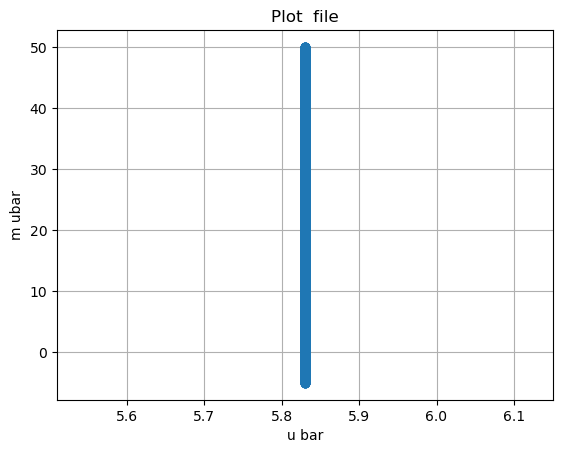

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the .dat file (adjust delimiter based on your file)
df = pd.read_csv("t1.000_U5.830.dat", delim_whitespace=True, comment="#", header=None)

# Optional: If file has headers, set header=0 instead of header=None
# df = pd.read_csv("data.dat", delim_whitespace=True, comment="#", header=0)

# If you know column names
# df.columns = ["Time", "Value1", "Value2"]
# Pick columns: col index starts from 0, so 2nd col = 1, 3rd col = 2
x = df.iloc[:, 1]
y = df.iloc[:, 2]

# Plot
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel("u bar")
plt.ylabel("m ubar")
plt.title("Plot  file")
plt.grid(True)
plt.show()

# Updated code for Generation of one-site data 
with 
- proper name
- parallel job execution for faster execution
- **Generated a (75651x7) dataset with U=15 (step 0.1) and Mu=50.0**
- this is ok dataset for g=1,2 mott insulators
-  *but for g=3 unknown prediction it fails cause of less training data*

In [3]:
import pandas as pd
import numpy as np
from scipy.linalg import eigh
from joblib import Parallel, delayed

def get_filename(t, U_end, U_step, mu_end, mu_step, suffix):
    """
    Generate a compact filename like:
    phase_t1.0_U15.0-(0.01)_Mu50.0-(0.001).csv
    """
    return f"phase_t{t:.1f}_U{U_end:.1f}-({U_step})_Mu{mu_end:.1f}-({mu_step}){suffix}"

def initialize_operators(dimf):
    """
        Initialize the annihilation (a), creation (a†), and number (n) operators
        as matrices in a truncated Fock space of size dimf.
        
        Returns:
            aDop: creation operator matrix (a†)
            aop: annihilation operator matrix (a)
            nop: number operator matrix (n = a†a)
            Umat: identity matrix of size dimf (used for φ²·I term)
    """
    aDop = np.zeros((dimf, dimf))
    aop = np.zeros((dimf, dimf))
    nop = np.zeros((dimf, dimf))
    Umat = np.identity(dimf)
    
    for bs in range(dimf):
        for ks in range(dimf):
            if bs == ks:
                nop[bs, ks] = ks                   # Diagonal: n|k⟩ = k|k⟩
            elif bs == ks + 1:
                aDop[bs, ks] = np.sqrt(ks + 1)     # a†|k⟩ = √(k+1)|k+1⟩
            elif bs == ks - 1:
                aop[bs, ks] = np.sqrt(ks)          # a|k⟩ = √k|k-1⟩
    
    return aDop, aop, nop, Umat

def construct_hamiltonian(dimf, t, U, cpc, phi, aDop, aop, nop, Umat):
    """
    Construct the mean-field decoupled single-site Hamiltonian matrix.
    
    H = -t·φ·(a + a†) + t·φ²·I + (U/2)·n(n-1) - μ·n

     ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \     # hopping term (mean-field decoupled)
                        + t * phi**2 * Umat[i, j] \               # φ²·I shift (mean-field correction)
                        + (U / 2.0) * (nop[i, j]**2 - nop[i, j]) \# on-site interaction energy
                        - cpc * nop[i, j]                         # chemical potential term (−μ·n)
            ham[j, i] = ham[i, j]  # Matrix is Hermitian (real symmetric here)
    
    Parameters:
        dimf : basis dimension
        t, U : hopping and interaction parameters
        cpc  : chemical potential μ (called "cpc" in code)
        phi  : current guess for superfluid order parameter φ
        aDop, aop, nop, Umat : operator matrices
    
    Returns:
        ham : Hamiltonian matrix (dimf x dimf)
    """
    ham = np.zeros((dimf, dimf))
    for i in range(dimf):
        for j in range(i + 1):
            ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \
                        + t * phi**2 * Umat[i, j] \
                        + (U / 2.0) * (nop[i, j]**2 - nop[i, j]) \
                        - cpc * nop[i, j]
            ham[j, i] = ham[i, j]   # Matrix is Hermitian (real symmetric here)
    return ham

def mean_field_iteration(dimf, t, U, cpc, aDop, aop, nop, Umat, max_iter=8000, tol=1e-6):
    """
    Self-consistently solve for the ground state at a given (t, U, μ) using mean-field theory.
    
    Steps:
    1. Start with initial φ (superfluid order parameter).
    2. Construct Hamiltonian using φ.
    3. Diagonalize to get ground state |ψ⟩.
    4. Compute:
        - ρ = ⟨ψ|n|ψ⟩ → density
        - φ_new = ⟨ψ|a|ψ⟩ → superfluid order parameter
    5. Iterate until φ converges.
    
    Returns:
        rho     : density ⟨n⟩
        phi²    : square of the superfluid order parameter (⟨a⟩²)
        eigval  : ground state energy
        iter_count : number of iterations to converge
    """


    phi = 0.2  # Initial guess for the superfluid order parameter φ
    for iter_count in range(max_iter):
        ham = construct_hamiltonian(dimf, t, U, cpc, phi, aDop, aop, nop, Umat)
        eigvals, eigvecs = eigh(ham)  # Diagonalize Hamiltonian
        
        ground_state = eigvecs[:, 0]  # Take the ground state |ψ⟩

         # Compute φ_new = ⟨ψ|a|ψ⟩ and ρ = ⟨ψ|n|ψ⟩
        phinew = np.sum(ground_state[:, None] * ground_state[None, :] * aDop)
        rho = np.sum(ground_state[:, None] * ground_state[None, :] * nop)


        # Check for convergence
        if abs(phinew - phi) < tol:
            return rho, phinew**2, eigvals[0], iter_count
        phi = phinew

    # If not converged, return anyway
    return rho, phinew**2, eigvals[0], max_iter

# def main():
#     dimf = 6  # Size of Fock basis (cutoff at max 5 particles per site)

#     t = 1.0   # Hopping amplitude (can be fixed to 1 without loss of generality)
#     U = 5.83  # On-site interaction strength

#     # Note: In this code, U and cpc are already in units of Ū = U / zt and μ̄ = μ / zt
#     # So there's no need to explicitly divide by zt again

#     cpc_start, cpc_end, cps = -5.0, 50.0, 0.01  # μ (cpc) range and step
#     suffix = ".dat"  # Output file extension
    
#     filename = get_filename(t, U, suffix)
#     aDop, aop, nop, Umat = initialize_operators(dimf)


    
#     with open(filename, "w") as f:
#         cpc = cpc_start
#         while cpc <= cpc_end:

#             # For each μ̄, solve the mean-field self-consistent problem
#             rho, rhos, eigval, iter_count = mean_field_iteration(dimf, t, U, cpc, aDop, aop, nop, Umat)
            
            
#             # Print and save results: t, Ū, μ̄, ρ, φ², ground state energy, iterations
#             result = f"{t:.2f} {U:.2f} {cpc:.3f} {rho:.4f} {rhos:.4f} {eigval:.10f} {iter_count}\n"
#             print(result, end="")
#             f.write(result)

#             # Increment μ
#             cpc += cps



def main():
    dimf = 6               # Size of Fock basis
    t = 1.0                # Hopping amplitude (fixed to 1)
    
    # Sweep ranges
    # Ū values
    U_start = 0.0
    U_end = 15.0
    U_step = 0.1
    
    # Calculate number of points
    num_U_points = int((U_end - U_start) / U_step) + 1
    U_list = np.linspace(U_start, U_end, num_U_points)

    
    # μ̄ values
    mu_start = -5.0
    mu_end = 50.0
    mu_step = 0.1

    # Calculate the number of points needed (inclusive of both ends)
    num_mu_points = int((mu_end - mu_start) / mu_step) + 1
    mu_list = np.linspace(mu_start, mu_end, num_mu_points)

    suffix = ".csv"
    filename = get_filename(t, U_end, U_step, mu_end, mu_step, suffix)

    aDop, aop, nop, Umat = initialize_operators(dimf)
    results = []

    # for U in U_list:
    #     for mu in mu_list:
    #         rho, phi2, energy, iter_count = mean_field_iteration(
    #             dimf, t, U, mu, aDop, aop, nop, Umat
    #         )

            
    #         results.append([t, U, mu, rho, phi2, energy, iter_count])

    #         # print(f"{U:.3f} {mu:.3f} {rho:.4f} {phi2:.4f} {energy:.6f}")

    # Function to evaluate one grid point (μ̄, Ū)
    def run_single_point(U, mu):
        rho, phi2, energy, iters = mean_field_iteration(dimf, t, U, mu, aDop, aop, nop, Umat)
        return [t, U, mu, rho, phi2, energy, iters]

    # Parallel evaluation of grid
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_single_point)(U, mu)
        for U in U_list
        for mu in mu_list
    )

    # Save to CSV
    df = pd.DataFrame(results, columns=["t", "Ubar", "Mubar", "Density", "Phi2", "Energy", "Iters"])
    print(df)
    df.to_csv(filename, index=False)
    print(f"\n✅ Saved phase diagram data to: {filename}")

if __name__ == "__main__":
    main()


<>:41: SyntaxWarning: invalid escape sequence '\ '
<>:41: SyntaxWarning: invalid escape sequence '\ '
C:\Users\DELL\AppData\Local\Temp\ipykernel_9524\2961418974.py:41: SyntaxWarning: invalid escape sequence '\ '
  """
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1760717979254167s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05566883087158203s.) Setting batch_size=4.
[Parallel(n_jobs=-

         t  Ubar  Mubar   Density      Phi2      Energy  Iters
0      1.0   0.0    0.0  3.508448  2.762672   -2.762672      1
1      1.0   0.0    0.1  3.587472  2.758786   -3.117533      3
2      1.0   0.0    0.2  3.659333  2.748061   -3.479928      4
3      1.0   0.0    0.3  3.725149  2.731654   -3.849198      4
4      1.0   0.0    0.4  3.785810  2.710462   -4.224786      5
...    ...   ...    ...       ...       ...         ...    ...
75646  1.0  15.0   49.6  3.923532  0.979353 -108.544199     27
75647  1.0  15.0   49.7  3.928223  0.960605 -108.936789     28
75648  1.0  15.0   49.8  3.932737  0.942246 -109.329838     29
75649  1.0  15.0   49.9  3.937079  0.924317 -109.723330     29
75650  1.0  15.0   50.0  3.941251  0.906863 -110.117248     30

[75651 rows x 7 columns]

✅ Saved phase diagram data to: phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv


✅ Dataset loaded: (75651, 7)


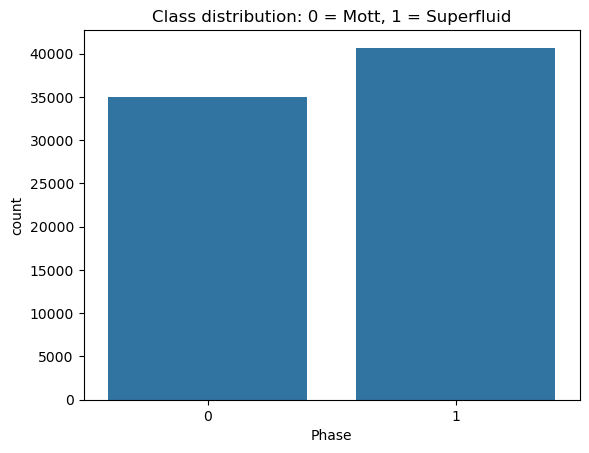

✅ Model trained

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      6994
           1       0.99      1.00      1.00      8137

    accuracy                           1.00     15131
   macro avg       1.00      1.00      1.00     15131
weighted avg       1.00      1.00      1.00     15131


🧩 Confusion Matrix:


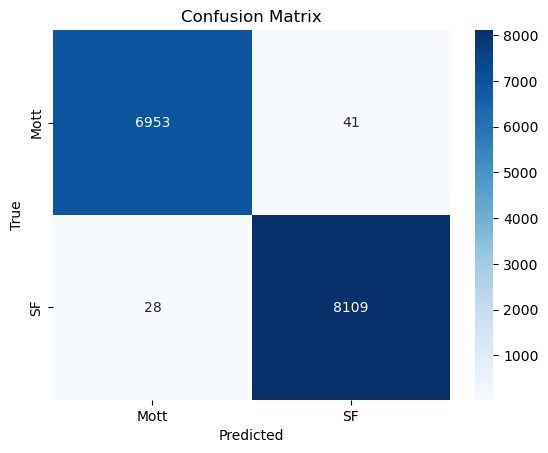

C:\Users\DELL\anaconda3\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: Input X contains infinity or a value too large for dtype('float32').

In [117]:
# Phase Diagram Classification Notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load the dataset (Update path if needed)
filename = "phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv"  # change if your filename differs
df = pd.read_csv(filename)
print("✅ Dataset loaded:", df.shape)

# Step 2: Add labels based on superfluid order parameter φ²
#         You can adjust the threshold (e.g., 1e-3) to distinguish phases
threshold = 1e-3
df['Phase'] = (df['Phi2'] > threshold).astype(int)  # 0 = Mott, 1 = Superfluid

# Optional: Display phase distribution
sns.countplot(data=df, x='Phase')
plt.title("Class distribution: 0 = Mott, 1 = Superfluid")
plt.show()

# Step 3: Prepare features and labels
X = df[['Ubar', 'Mubar']]   # Features (normalized chemical potential and interaction)
y = df['Phase']             # Labels

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 5: Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("✅ Model trained")

# Step 6: Evaluation
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧩 Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Mott", "SF"], yticklabels=["Mott", "SF"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# # Step 7: Plot decision boundary
# from matplotlib.colors import ListedColormap

# def plot_decision_boundary(model, X, y):
#     x_min, x_max = X['Ubar'].min(), X['Ubar'].max()
#     y_min, y_max = X['Mubar'].min(), X['Mubar'].max()
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
#                          np.linspace(y_min, y_max, 300))
    
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     plt.figure(figsize=(8, 6))
#     plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['gray', 'orange']))
#     plt.scatter(X['Ubar'], X['Mubar'], c=y, s=10, cmap=ListedColormap(['blue', 'red']))
#     plt.xlabel("Ū")
#     plt.ylabel("μ̄")
#     plt.title("Phase Classification Decision Boundary")
#     plt.grid(True)
#     plt.show()

# plot_decision_boundary(clf, X, y)
def plot_decision_boundary_invU(model, X, y):
    # Transform Ubar to 1/Ubar
    invU = 1 / X['Ubar']
    invMU = 1/ X['Mubar']
    
    x_min, x_max = , invU.max()
    y_min, y_max =1, invMU.max()
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    
    # When predicting, convert back from 1/U to U
    Z = model.predict(np.c_[1/xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['gray', 'orange']))
    plt.scatter(invU, X['Mubar'], c=y, s=10, cmap=ListedColormap(['blue', 'red']))
    plt.xlabel("1/Ū")
    plt.ylabel("μ̄")
    plt.title("Phase Classification Decision Boundary (1/U)")
    plt.grid(True)
    plt.show()

# Call it
plot_decision_boundary_invU(clf, X, y)



✅ Model trained

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.44      0.50      8081
           1       0.77      0.86      0.81     17470

    accuracy                           0.72     25551
   macro avg       0.67      0.65      0.65     25551
weighted avg       0.71      0.72      0.71     25551


🧩 Confusion Matrix:


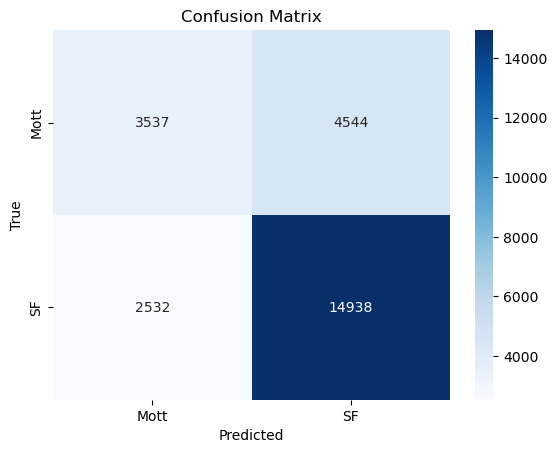

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


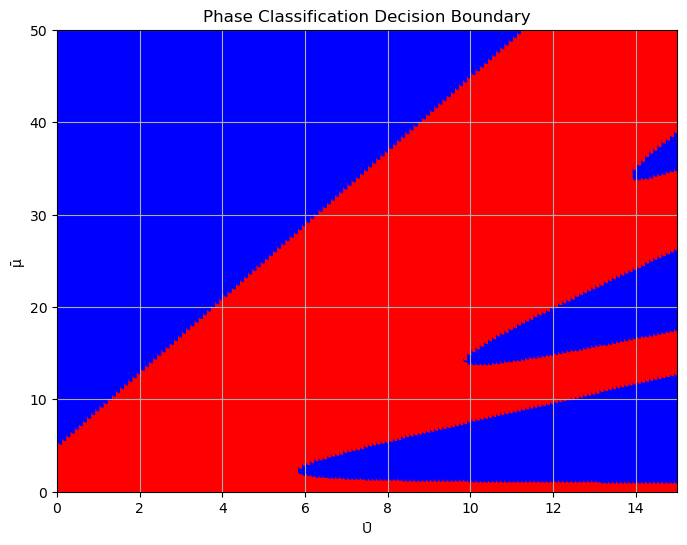

In [19]:
# Example: hold out entire ranges of Ubar (like extrapolation)
test_U_range = (10.0, 15.0)
mask = (df['Ubar'] >= test_U_range[0]) & (df['Ubar'] <= test_U_range[1])

X_train = df.loc[~mask, ['Ubar', 'Mubar']]
y_train = df.loc[~mask, 'Phase']
X_test = df.loc[mask, ['Ubar', 'Mubar']]
y_test = df.loc[mask, 'Phase']

# Step 5: Train classifier
clf = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("✅ Model trained")

# Step 6: Evaluation
y_pred = clf.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧩 Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Mott", "SF"], yticklabels=["Mott", "SF"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Step 7: Plot decision boundary
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y):
    x_min, x_max = X['Ubar'].min(), X['Ubar'].max()
    y_min, y_max = X['Mubar'].min(), X['Mubar'].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['gray', 'orange']))
    plt.scatter(X['Ubar'], X['Mubar'], c=y, s=10, cmap=ListedColormap(['blue', 'red']))
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Phase Classification Decision Boundary")
    plt.grid(True)
    plt.show()

plot_decision_boundary(clf, X, y)


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


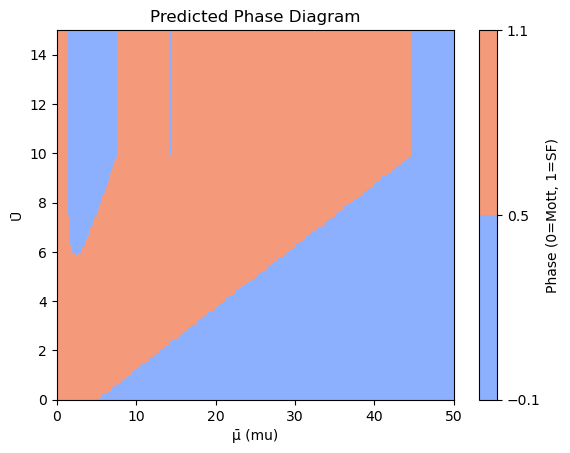

In [21]:
# Suppose you trained a classifier `model`
# And now want to predict for new μ̄ and Ū values

new_U_values = np.linspace(0, 15, 200)
new_mu_values = np.linspace(0, 50, 200)

# Create prediction grid
grid = np.array([[U, mu] for U in new_U_values for mu in new_mu_values])

# Predict the phase (0 = Mott, 1 = SF)
predicted_phases = clf.predict(grid)

# You can now plot the phase diagram
import matplotlib.pyplot as plt

U_grid = grid[:, 0].reshape(len(new_U_values), len(new_mu_values))
mu_grid = grid[:, 1].reshape(len(new_U_values), len(new_mu_values))
phase_grid = predicted_phases.reshape(len(new_U_values), len(new_mu_values))

plt.contourf(mu_grid, U_grid, phase_grid, levels=[-0.1, 0.5, 1.1], cmap='coolwarm')
plt.xlabel("μ̄ (mu)")
plt.ylabel("Ū")
plt.title("Predicted Phase Diagram")
plt.colorbar(label="Phase (0=Mott, 1=SF)")
plt.show()


# Random Forest Classifier
## RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=0)

## Training

In [23]:
# Features and labels
X = df[["Ubar", "Mubar"]]
y = df["Phase"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Random Forest classifier with class balancing
model2 = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=0)
model2.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("✅ Model trained\n")
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))


✅ Model trained

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     10491
           1       0.90      0.94      0.92     12205

    accuracy                           0.91     22696
   macro avg       0.91      0.91      0.91     22696
weighted avg       0.91      0.91      0.91     22696



# Prediction (Testing)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


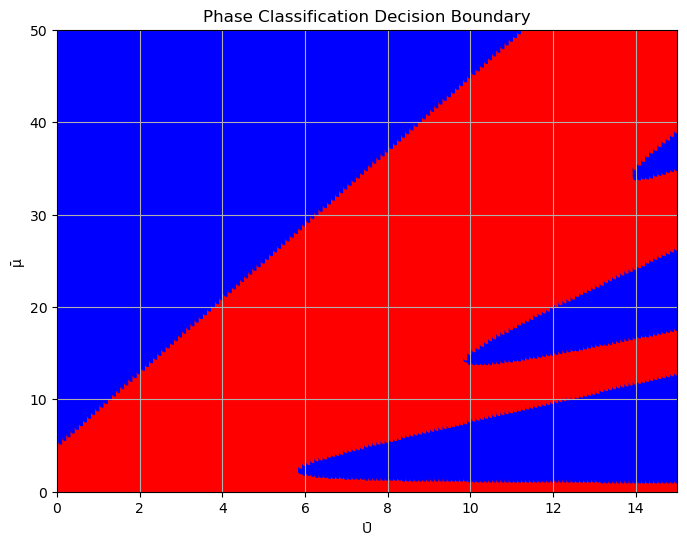

In [25]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(["gray", "orange"]))
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(["blue", "red"]))
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Phase Classification Decision Boundary")
    plt.grid(True)
    plt.show()

plot_decision_boundary(model2, X, y)



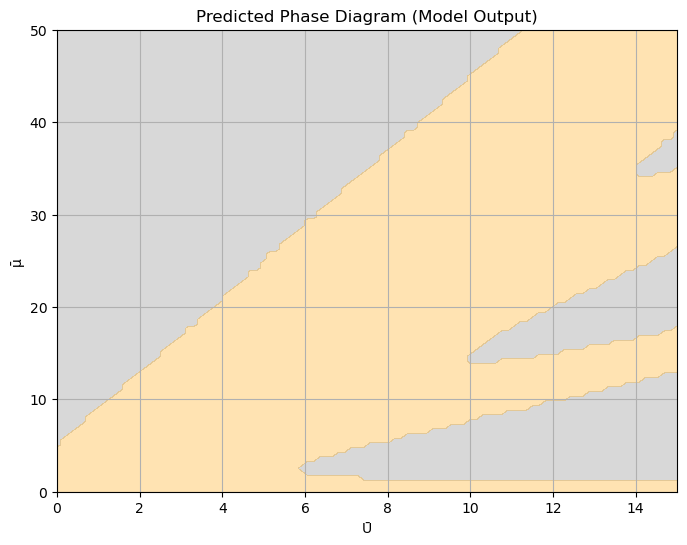

In [27]:
# Define new range (test on unseen Ū, μ̄)
U_new = np.linspace(0, 15, 100)
mu_new = np.linspace(0, 50, 100)
uu, mm = np.meshgrid(U_new, mu_new)
grid = pd.DataFrame({"Ubar": uu.ravel(), "Mubar": mm.ravel()})

# Predict phase
grid["Phase"] =model2 .predict(grid)

# Plot predicted phase map
plt.figure(figsize=(8, 6))
plt.contourf(uu, mm, grid["Phase"].values.reshape(uu.shape),
             levels=1, alpha=0.3, cmap=ListedColormap(["gray", "orange"]))
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Phase Diagram (Model Output)")
plt.grid(True)
plt.show()


# Random Forest Regressor 
## RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)

Results are bad bad

✅ Model trained

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.31      0.47      8748
           1       0.63      1.00      0.77     10165

    accuracy                           0.68     18913
   macro avg       0.81      0.65      0.62     18913
weighted avg       0.80      0.68      0.63     18913



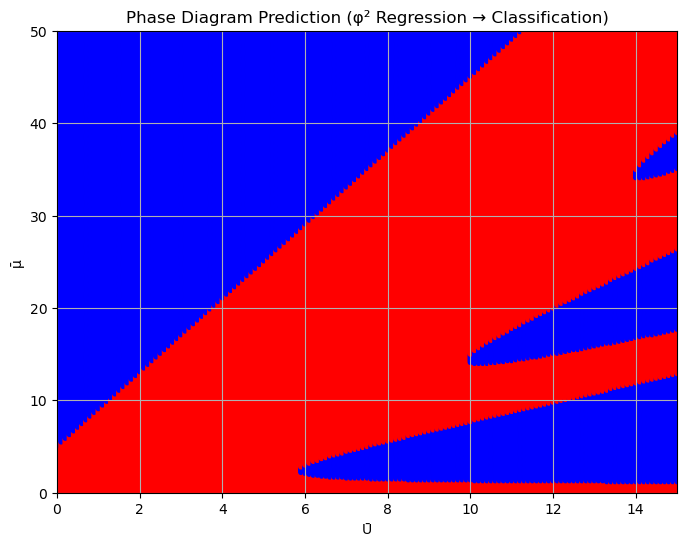

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap

# Step 1: Load your dataset
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")  # change filename if needed

# Step 2: Set threshold for classifying phase
phi2_threshold = 1e-6
df["PhaseLabel"] = (df["Phi2"] > phi2_threshold).astype(int)  # 0 = Mott, 1 = SF

# Step 3: Define features and target
X = df[["Ubar", "Mubar"]]
y_phi2 = df["Phi2"]              # Regression target
y_phase = df["PhaseLabel"]       # Classification label (derived)

# Step 4: Train-test split
X_train, X_test, y_phi2_train, y_phi2_test, y_phase_train, y_phase_test = train_test_split(
    X, y_phi2, y_phase, test_size=0.25, random_state=42
)

# Step 5: Train a regression model (Random Forest)
reg = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0)
reg.fit(X_train, y_phi2_train)

# Step 6: Predict φ² on test set and classify
y_phi2_pred = reg.predict(X_test)
y_phase_pred = (y_phi2_pred > phi2_threshold).astype(int)

# Step 7: Evaluate performance
print("✅ Model trained\n")
print("📊 Classification Report:")
print(classification_report(y_phase_test, y_phase_pred))

# Step 8: Plot decision boundary
def plot_decision_boundary(model, X, y_true, threshold=1e-6):
    x_min, x_max = X['Ubar'].min(), X['Ubar'].max()
    y_min, y_max = X['Mubar'].min(), X['Mubar'].max()
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    
    grid = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    phi2_pred = model.predict(grid)
    phase_pred = (phi2_pred > threshold).astype(int)
    
    Z = phase_pred.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['gray', 'orange']))
    plt.scatter(X["Ubar"], X["Mubar"], c=y_true, s=8, cmap=ListedColormap(['blue', 'red']))
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Phase Diagram Prediction (φ² Regression → Classification)")
    plt.grid(True)
    plt.show()

plot_decision_boundary(reg, X, y_phase)


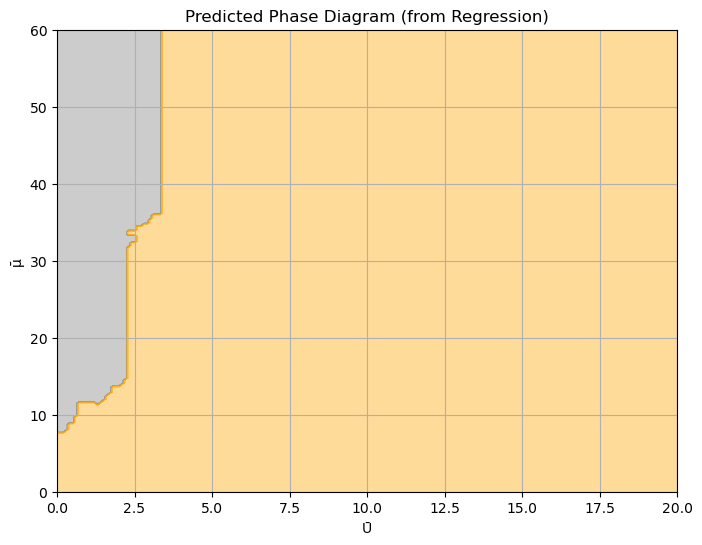

In [33]:
# Define grid over new ranges (you can go beyond your training data cautiously)
U_vals = np.linspace(0.0, 20.0, 200)
mu_vals = np.linspace(0.0, 60.0, 200)
UU, MM = np.meshgrid(U_vals, mu_vals)

grid_points = pd.DataFrame({
    "Ubar": UU.ravel(),
    "Mubar": MM.ravel()
})

# Predict φ² for each grid point
phi2_grid_pred = reg.predict(grid_points)
phase_grid_pred = (phi2_grid_pred > phi2_threshold).astype(int)
phase_map = phase_grid_pred.reshape(UU.shape)

# Plot it
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.figure(figsize=(8, 6))
plt.contourf(UU, MM, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.4)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Phase Diagram (from Regression)")
plt.grid(True)
plt.show()


# Random Forest Classifier
## RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)


📊 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8704
           1       0.99      1.00      0.99     10209

    accuracy                           0.99     18913
   macro avg       0.99      0.99      0.99     18913
weighted avg       0.99      0.99      0.99     18913



C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


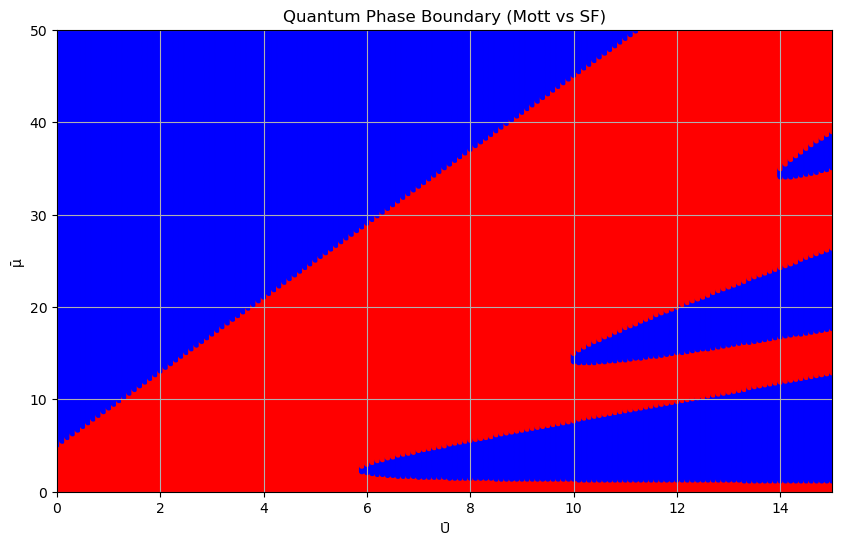

Superfluid


In [35]:
# Phase classification using φ² threshold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap

# 1. Load Data
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")  # Replace with your filename

# 2. Add labels: 0 = Mott Insulator, 1 = Superfluid
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# 3. Select features and target
X = df[["Ubar", "Mubar"]]
y = df["Phase"]

# 4. Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 5. Normalize input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
clf.fit(X_train_scaled, y_train)

# 7. Evaluate performance
y_pred = clf.predict(X_test_scaled)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# 8. Plot decision boundary
def plot_decision_boundary(model, scaler, X, y):
    x_min, x_max = X['Ubar'].min(), X['Ubar'].max()
    y_min, y_max = X['Mubar'].min(), X['Mubar'].max()

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Scale the grid points
    grid_scaled = scaler.transform(np.c_[xx.ravel(), yy.ravel()])
    Z = model.predict(grid_scaled)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.4)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, cmap=ListedColormap(['blue', 'red']), s=10)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Quantum Phase Boundary (Mott vs SF)")
    plt.grid(True)
    plt.show()

plot_decision_boundary(clf, scaler, X, y)

# 9. Predict on new (Ubar, Mubar) values
def predict_phase(model, scaler, Ubar, Mubar):
    X_new = pd.DataFrame({"Ubar": [Ubar], "Mubar": [Mubar]})
    X_scaled = scaler.transform(X_new)
    phase = model.predict(X_scaled)[0]
    return "Superfluid" if phase == 1 else "Mott Insulator"

# Example
print(predict_phase(clf, scaler, Ubar=10.5, Mubar=15.2))


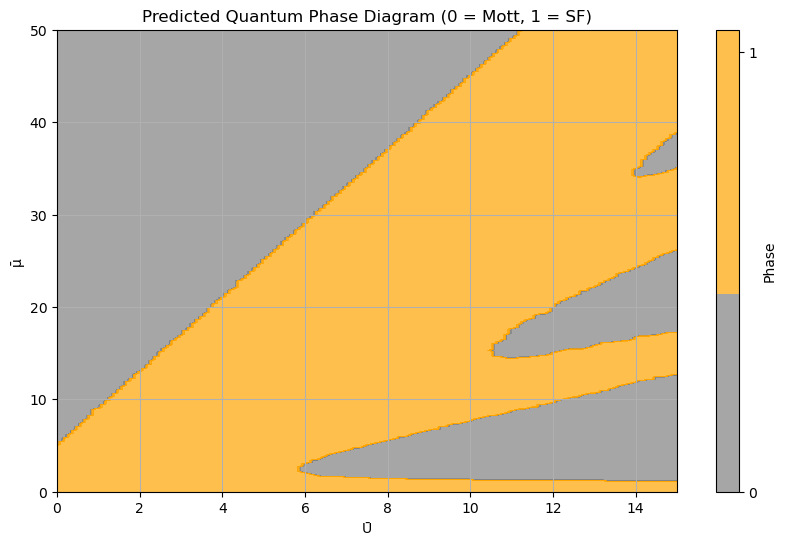

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define prediction grid
U_min, U_max = 0.0, 15.0
mu_min, mu_max = 0.0, 50.0
U_step = 0.1
mu_step = 0.1

# Create grid
U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

# Flatten for prediction
grid_points = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

# Normalize with the same scaler used in training
grid_scaled = scaler.transform(grid_points)

# Predict phases on the grid
predicted_phases = clf.predict(grid_scaled)
predicted_phase_map = predicted_phases.reshape(U_grid.shape)

# Plot predicted phase diagram
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, predicted_phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Quantum Phase Diagram (0 = Mott, 1 = SF)")
plt.grid(True)
plt.show()


## same model with confusion matrix and more precised values(until 4 decimal points) in classification report


📊 Classification Report (Model vs True):
              precision    recall  f1-score   support

           0     0.9978    0.9931    0.9955     34816
           1     0.9942    0.9981    0.9962     40835

    accuracy                         0.9958     75651
   macro avg     0.9960    0.9956    0.9958     75651
weighted avg     0.9958    0.9958    0.9958     75651



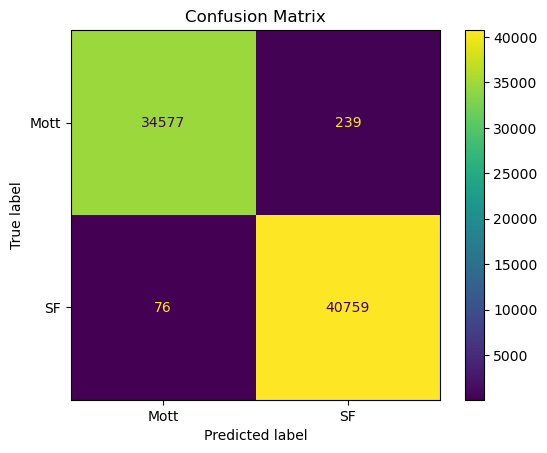

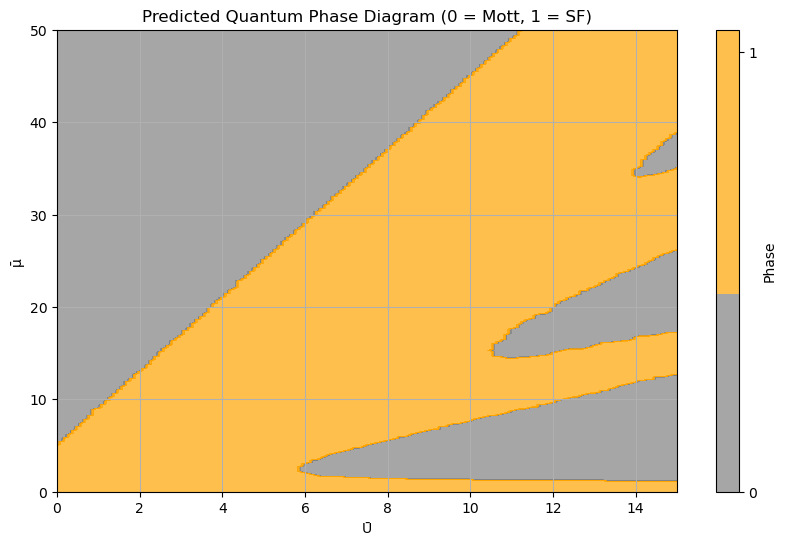

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ------------------------
# 1. Define prediction grid
# ------------------------
U_min, U_max = 0.0, 15.0
mu_min, mu_max = 0.0, 50.0
U_step = 0.1
mu_step = 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_points = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

# ------------------------
# 2. Predict on grid
# ------------------------
grid_scaled = scaler.transform(grid_points)
predicted_phases = clf.predict(grid_scaled)
predicted_phase_map = predicted_phases.reshape(U_grid.shape)

# ------------------------
# 3. Load ground truth
# ------------------------
df_true = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")
df_true["Phase"] = (df_true["Phi2"] > 1e-6).astype(int)

# ------------------------
# 4. Evaluate accuracy
# ------------------------
X_true = df_true[["Ubar", "Mubar"]]
y_true = df_true["Phase"]
X_true_scaled = scaler.transform(X_true)
y_pred = clf.predict(X_true_scaled)

# Print metrics
print("\n📊 Classification Report (Model vs True):")
print(classification_report(y_true, y_pred, digits=4))

# Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mott", "SF"])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# ------------------------
# 5. Plot predicted phase diagram
# ------------------------
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, predicted_phase_map,
             cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Quantum Phase Diagram (0 = Mott, 1 = SF)")
plt.grid(True)
plt.show()


# All Three Models at once Random Forest, SVM, MLP


models = {

    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
     
     "SVM": SVC(kernel='poly', degree=3, C=1.0),
    
    "MLP": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42),
}


📊 Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8704
           1       0.99      1.00      0.99     10209

    accuracy                           0.99     18913
   macro avg       0.99      0.99      0.99     18913
weighted avg       0.99      0.99      0.99     18913


📊 Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.84      0.54      0.66      8704
           1       0.70      0.91      0.79     10209

    accuracy                           0.74     18913
   macro avg       0.77      0.73      0.73     18913
weighted avg       0.77      0.74      0.73     18913


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8704
           1       0.99      1.00      0.99     10209

    accuracy                           0.99     18913
   macro avg     

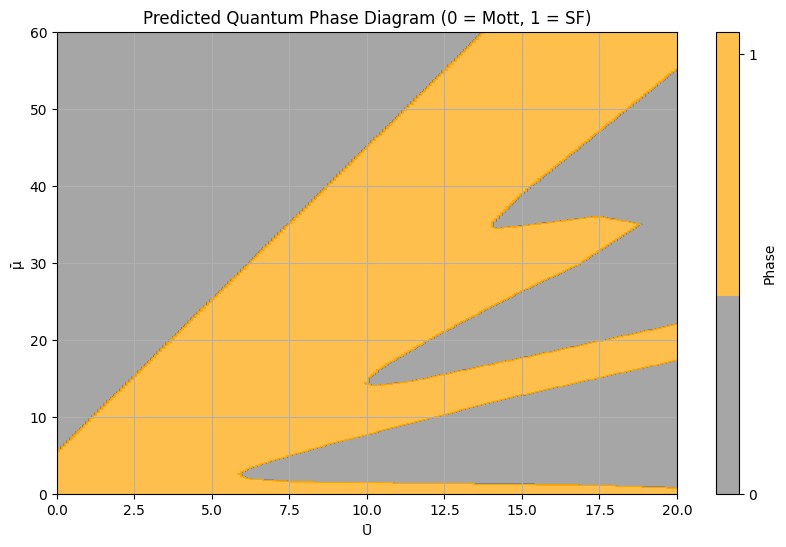

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap

# Load dataset
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label phases
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target
X = df[["Ubar", "Mubar"]]
y = df["Phase"]

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "SVM": SVC(kernel='poly', degree=3, C=1.0),
    "MLP": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42),
    # "GPC": GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

# Pick one model for grid prediction
clf = models["MLP"]  # Change to "GPC", "SVM", or "RandomForest" as needed

# Prediction grid
U_min, U_max, mu_min, mu_max = 0.0, 20.0, 0.0, 60.0
U_step, mu_step = 0.1, 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_points = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})
grid_scaled = scaler.transform(grid_points)
predicted_phases = clf.predict(grid_scaled)
predicted_phase_map = predicted_phases.reshape(U_grid.shape)

# Plot predicted phase diagram
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, predicted_phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Quantum Phase Diagram (0 = Mott, 1 = SF)")
plt.grid(True)
plt.show()


## Random Forest


📊 Classification Report (Model vs True):
              precision    recall  f1-score   support

           0     0.9978    0.9931    0.9955     34816
           1     0.9942    0.9981    0.9962     40835

    accuracy                         0.9958     75651
   macro avg     0.9960    0.9956    0.9958     75651
weighted avg     0.9958    0.9958    0.9958     75651



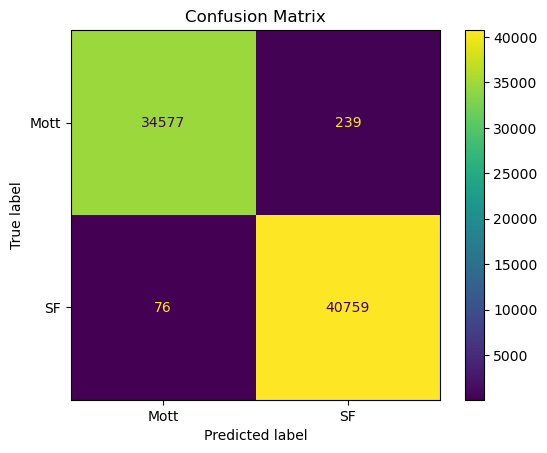

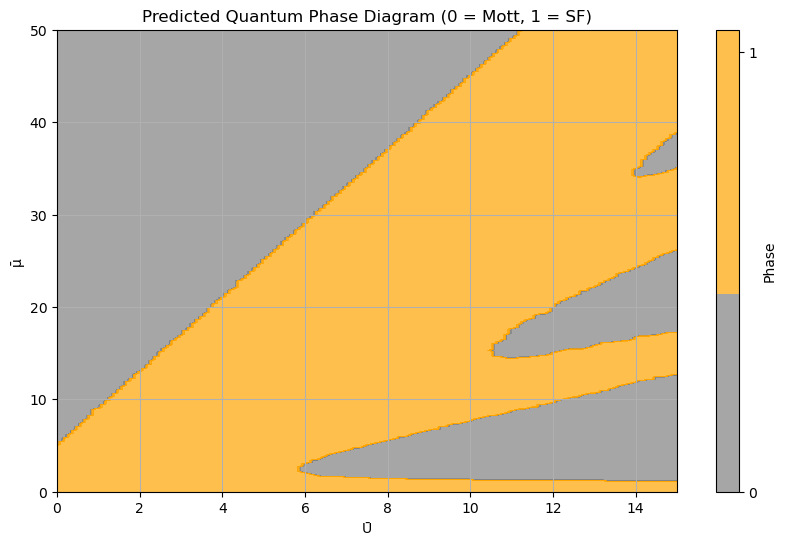

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ------------------------
# 1. Define prediction grid
# ------------------------
U_min, U_max = 0.0, 15.0
mu_min, mu_max = 0.0, 50.0
U_step = 0.1
mu_step = 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_points = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

# Pick one model for grid prediction
clf = models["RandomForest"]  # Change to "GPC", "SVM", or "RandomForest" as needed
# ------------------------
# 2. Predict on grid
# ------------------------
grid_scaled = scaler.transform(grid_points)
predicted_phases = clf.predict(grid_scaled)
predicted_phase_map = predicted_phases.reshape(U_grid.shape)

# ------------------------
# 3. Load ground truth
# ------------------------
df_true = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")
df_true["Phase"] = (df_true["Phi2"] > 1e-6).astype(int)

# ------------------------
# 4. Evaluate accuracy
# ------------------------
X_true = df_true[["Ubar", "Mubar"]]
y_true = df_true["Phase"]
X_true_scaled = scaler.transform(X_true)
y_pred = clf.predict(X_true_scaled)

# Print metrics
print("\n📊 Classification Report (Model vs True):")
print(classification_report(y_true, y_pred, digits=4))

# Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mott", "SF"])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# ------------------------
# 5. Plot predicted phase diagram
# ------------------------
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, predicted_phase_map,
             cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Quantum Phase Diagram (0 = Mott, 1 = SF)")
plt.grid(True)
plt.show()


## MLP
"MLP": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42)


📊 Classification Report (Model vs True):
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



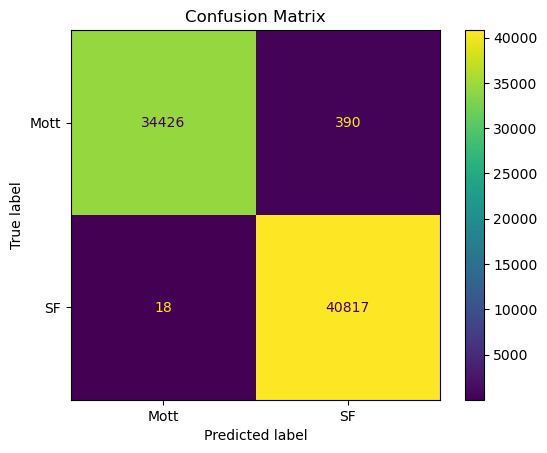

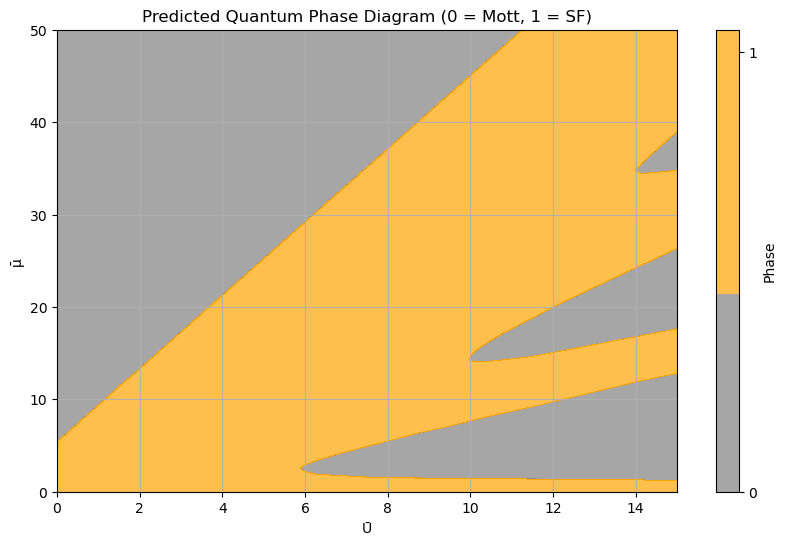

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ------------------------
# 1. Define prediction grid
# ------------------------
U_min, U_max = 0.0, 15.0
mu_min, mu_max = 0.0, 50.0
U_step = 0.01
mu_step = 0.01

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_points = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

# Pick one model for grid prediction
clf = models["MLP"]  # Change to "GPC", "SVM", or "RandomForest" as needed
# ------------------------
# 2. Predict on grid
# ------------------------
grid_scaled = scaler.transform(grid_points)
predicted_phases = clf.predict(grid_scaled)
predicted_phase_map = predicted_phases.reshape(U_grid.shape)

# ------------------------
# 3. Load ground truth
# ------------------------
df_true = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")
df_true["Phase"] = (df_true["Phi2"] > 1e-6).astype(int)

# ------------------------
# 4. Evaluate accuracy
# ------------------------
X_true = df_true[["Ubar", "Mubar"]]
y_true = df_true["Phase"]
X_true_scaled = scaler.transform(X_true)
y_pred = clf.predict(X_true_scaled)

# Print metrics
print("\n📊 Classification Report (Model vs True):")
print(classification_report(y_true, y_pred, digits=4))

# Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mott", "SF"])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# ------------------------
# 5. Plot predicted phase diagram
# ------------------------
plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, predicted_phase_map,
             cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Quantum Phase Diagram (0 = Mott, 1 = SF)")
plt.grid(True)
plt.show()


In [ ]:
# # 9. Predict on new (Ubar, Mubar) values
# def predict_phase(model, scaler, Ubar, Mubar):
#     X_new = pd.DataFrame({"Ubar": [Ubar], "Mubar": [Mubar]})
#     X_scaled = scaler.transform(X_new)
#     phase = model.predict(X_scaled)[0]
#     return "Superfluid" if phase == 1 else "Mott Insulator"

def predict_phase_at(Ubar, Mubar):
    """

In [ ]:
    Predict the phase (0 = Mott, 1 = Superfluid) at a given Ū and μ̄.
    """
    X_new = pd.DataFrame({"Ubar": [Ubar], "Mubar": [Mubar]})
    X_scaled = scaler.transform(X_new)
    phase = clf.predict(X_scaled)[0]
    label = "Superfluid" if phase == 1 else "Mott Insulator"
    return phase, label

U_test = 5.9
mu_test = 1.2

phase, label = predict_phase_at(U_test, mu_test)
print(f"At Ū = {U_test}, μ̄ = {mu_test} → Phase: {label} ({phase})")

At Ū = 5.9, μ̄ = 1.2 → Phase: Superfluid (1)


## SVM


📊 Classification Report (Model vs True):
              precision    recall  f1-score   support

           0     0.8389    0.5374    0.6551     34793
           1     0.6984    0.9121    0.7911     40858

    accuracy                         0.7398     75651
   macro avg     0.7686    0.7247    0.7231     75651
weighted avg     0.7630    0.7398    0.7285     75651



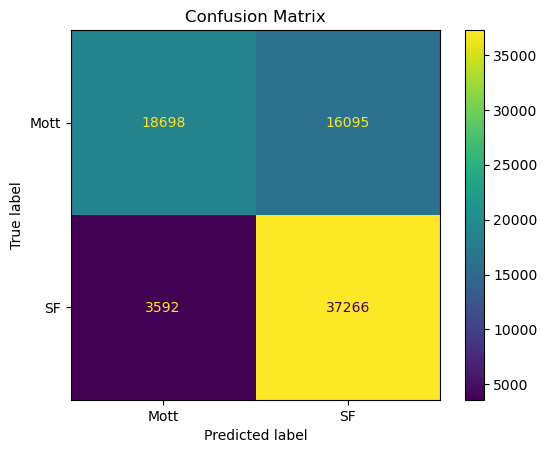

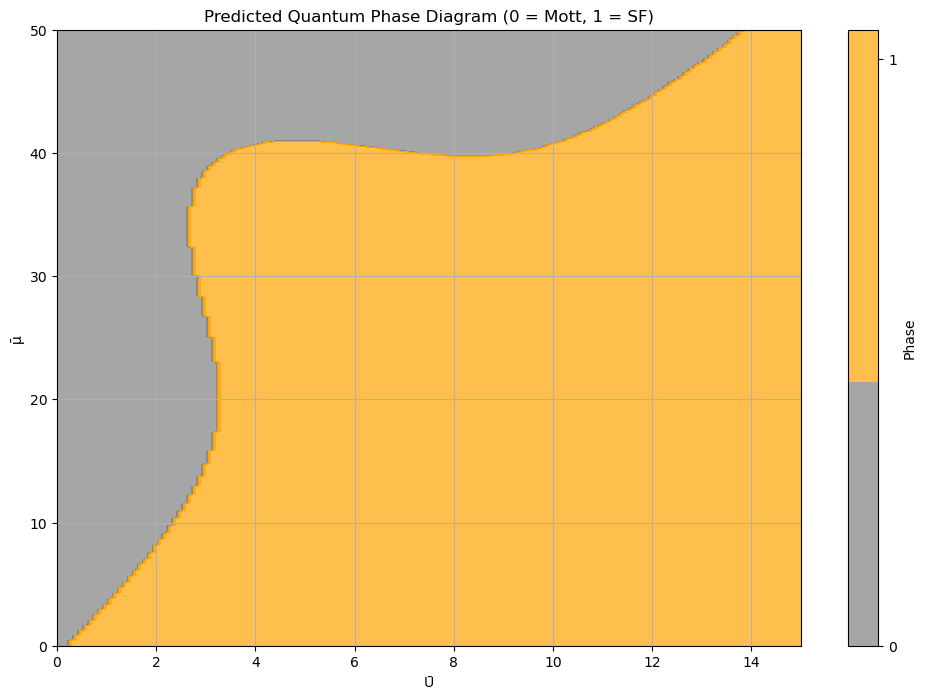

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# ------------------------
# 1. Define prediction grid
# ------------------------
U_min, U_max = 0.0, 15.0
mu_min, mu_max = 0.0, 50.0
U_step = 0.1
mu_step = 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_points = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

# Pick one model for grid prediction
clf = models["SVM"]  # Change to "GPC", "SVM", or "RandomForest" as needed
# ------------------------
# 2. Predict on grid
# ------------------------
grid_scaled = scaler.transform(grid_points)
predicted_phases = clf.predict(grid_scaled)
predicted_phase_map = predicted_phases.reshape(U_grid.shape)

# ------------------------
# 3. Load ground truth
# ------------------------
df_true = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")
df_true["Phase"] = (df_true["Phi2"] > 1e-7).astype(int)

# ------------------------
# 4. Evaluate accuracy
# ------------------------
X_true = df_true[["Ubar", "Mubar"]]
y_true = df_true["Phase"]
X_true_scaled = scaler.transform(X_true)
y_pred = clf.predict(X_true_scaled)

# Print metrics
print("\n📊 Classification Report (Model vs True):")
print(classification_report(y_true, y_pred, digits=4))

# Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mott", "SF"])
disp.plot(cmap="viridis")
plt.title("Confusion Matrix")
plt.show()

# ------------------------
# 5. Plot predicted phase diagram
# ------------------------
plt.figure(figsize=(12, 8))
plt.contourf(U_grid, mu_grid, predicted_phase_map,
             cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Quantum Phase Diagram (0 = Mott, 1 = SF)")
plt.grid(True)
plt.show()


# discarded

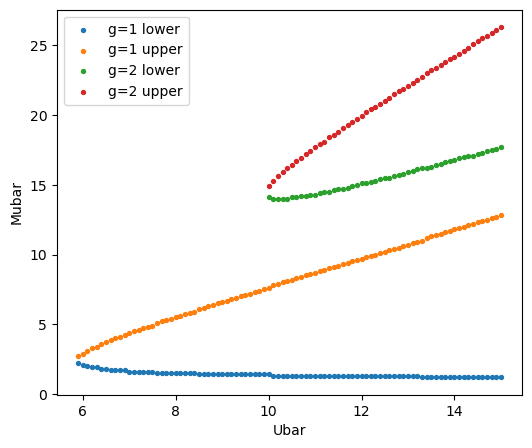

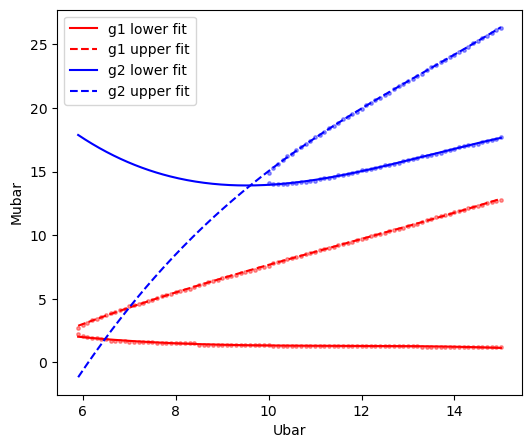

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# load dataframe (must contain Ubar, Mubar, Phi2, Density)
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# parameters
phi2_thresh = 1e-6
eps_density = 0.05   # how close density must be to integer g
U_bins = np.unique(np.round(df['Ubar'], 4))  # or use np.linspace(min,max,n)

def extract_lobe_bounds(df, g, U_bins, eps_density=0.1, phi2_thresh=1e-6):
    """Return arrays (U_list, mu_lower_list, mu_upper_list) for Mott lobe g."""
    U_list = []
    mu_low = []
    mu_high = []
    # for each U value, find mu where density ~ g and phi2 small
    for U in U_bins:
        sub = df[np.isclose(df['Ubar'], U)]
        if sub.empty: 
            continue
        # sort by mu
        sub = sub.sort_values('Mubar')
        # identify points where density is approx g AND phi2 small (Mott plateau)
        mask_plateau = (np.abs(sub['Density'] - g) <= eps_density) & (sub['Phi2'] <= phi2_thresh)
        if mask_plateau.any():
            mus = sub.loc[mask_plateau, 'Mubar'].values
            # lower and upper mu of the plateau at this U
            mu_lo = mus.min()
            mu_hi = mus.max()
            U_list.append(U)
            mu_low.append(mu_lo)
            mu_high.append(mu_hi)
        else:
            # alternative approach: find mu where phi2 crosses threshold (SF boundary)
            # find first mu where phi2 > thresh (enter SF) and before was MI -> use that as upper/lower
            # for simplicity skip if no plateau
            continue
    return np.array(U_list), np.array(mu_low), np.array(mu_high)

# example for g = 1 and 2
U1, mu1_lo, mu1_hi = extract_lobe_bounds(df, g=1, U_bins=U_bins, eps_density=0.05, phi2_thresh=1e-6)
U2, mu2_lo, mu2_hi = extract_lobe_bounds(df, g=2, U_bins=U_bins, eps_density=0.05, phi2_thresh=1e-6)

# quick plotting of raw boundaries
plt.figure(figsize=(6,5))
plt.scatter(U1, mu1_lo, s=8, label='g=1 lower')
plt.scatter(U1, mu1_hi, s=8, label='g=1 upper')
plt.scatter(U2, mu2_lo, s=8, label='g=2 lower')
plt.scatter(U2, mu2_hi, s=8, label='g=2 upper')
plt.xlabel('Ubar'); plt.ylabel('Mubar'); plt.legend()
plt.show()

# Fit splines (s smoothing factor tuneable)
spline1_lo = UnivariateSpline(U1, mu1_lo, s=0.5)  # s ~ smoothing; increase to smooth more
spline1_hi = UnivariateSpline(U1, mu1_hi, s=0.5)
spline2_lo = UnivariateSpline(U2, mu2_lo, s=0.5)
spline2_hi = UnivariateSpline(U2, mu2_hi, s=0.5)

# evaluate and plot fitted curves
U_plot = np.linspace(U1.min(), U1.max(), 300)
plt.figure(figsize=(6,5))
plt.plot(U_plot, spline1_lo(U_plot), 'r-', label='g1 lower fit')
plt.plot(U_plot, spline1_hi(U_plot), 'r--', label='g1 upper fit')
plt.plot(U_plot, spline2_lo(U_plot), 'b-', label='g2 lower fit')
plt.plot(U_plot, spline2_hi(U_plot), 'b--', label='g2 upper fit')
plt.scatter(U1, mu1_lo, s=6, c='r', alpha=0.4)
plt.scatter(U1, mu1_hi, s=6, c='r', alpha=0.4)
plt.scatter(U2, mu2_lo, s=6, c='b', alpha=0.4)
plt.scatter(U2, mu2_hi, s=6, c='b', alpha=0.4)
plt.xlabel('Ubar'); plt.ylabel('Mubar'); plt.legend(); plt.show()


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap

# ------------------------------
# 1. Load dataset
# ------------------------------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label phases (0 = Mott, 1 = SF)
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# ------------------------------
# 2. Add physics-informed features
# ------------------------------
df["Mu_over_U"] = df["Mubar"] / df["Ubar"].replace(0, np.nan)  # avoid div by zero
df["U_times_mu"] = df["Ubar"] * df["Mubar"]
df["DistFill"] = (df["Density"] - df["Density"].round())**2

# Replace NaNs with 0
df = df.fillna(0)

# ------------------------------
# 3. Select features & target
# ------------------------------
feature_cols = [
    "Ubar", "Mubar",       # original parameters
    "Density", "Phi2",     # physical order parameters
    "Energy", "Iters",     # solver outputs
    "Mu_over_U", "U_times_mu", "DistFill"  # derived features
]
X = df[feature_cols]
y = df["Phase"]

# ------------------------------
# 4. Train-test split + scaling
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 5. Train models
# ------------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42),
    "SVM": SVC(kernel='poly', degree=3, C=1.0),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=800, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


📊 Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8704
           1       1.00      1.00      1.00     10209

    accuracy                           1.00     18913
   macro avg       1.00      1.00      1.00     18913
weighted avg       1.00      1.00      1.00     18913


📊 Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8704
           1       1.00      0.98      0.99     10209

    accuracy                           0.99     18913
   macro avg       0.99      0.99      0.99     18913
weighted avg       0.99      0.99      0.99     18913


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8704
           1       1.00      1.00      1.00     10209

    accuracy                           1.00     18913
   macro avg     

## No leak Classifiers 

Training models (no leakage features)...

📊 Classification Report for RandomForest:
              precision    recall  f1-score   support

           0     0.9961    0.9975    0.9968      8704
           1     0.9978    0.9967    0.9973     10209

    accuracy                         0.9970     18913
   macro avg     0.9970    0.9971    0.9970     18913
weighted avg     0.9970    0.9970    0.9970     18913

📊 Classification Report for SVM:
              precision    recall  f1-score   support

           0     0.9864    0.9724    0.9793      8704
           1     0.9768    0.9885    0.9826     10209

    accuracy                         0.9811     18913
   macro avg     0.9816    0.9805    0.9810     18913
weighted avg     0.9812    0.9811    0.9811     18913

📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9984    0.9945    0.9964      8704
           1     0.9953    0.9986    0.9970     10209

    accuracy                    

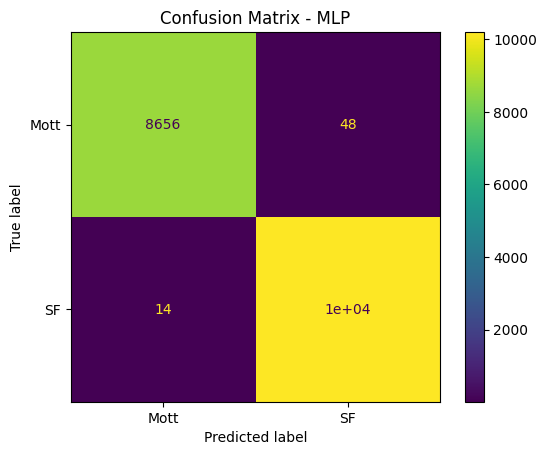

In [8]:
# ==============================
# NO-LEAK PHASE CLASSIFIER (Ū, μ̄ ONLY + ENGINEERED FEATURES)
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import ListedColormap

# -----------------------------
# 1) Load data and create labels (ONLY for training targets)
# -----------------------------
csv_path = "phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv"  # <-- change if needed
df = pd.read_csv(csv_path)

# Label: 1 = Superfluid, 0 = Mott
# We will NOT use Phi2 as a feature; only as target to define labels.
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# -----------------------------
# 2) Feature engineering without leakage
# Only use Ubar and Mubar and transformations of those that are available at prediction time.
# -----------------------------
def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    """
    Build a feature set from Ubar, Mubar that the model can use at prediction time.
    NO Phi2, Energy, Density, etc. Only functions of (Ubar, Mubar).
    """
    X = pd.DataFrame(index=df_in.index)
    U = df_in["Ubar"].values.astype(float)
    MU = df_in["Mubar"].values.astype(float)

    eps = 1e-6  # to avoid division by zero

    # Base features
    X["Ubar"] = U
    X["Mubar"] = MU

    # Simple nonlinear / interaction terms
    X["U_times_mu"] = U * MU
    X["U_sq"] = U**2
    X["mu_sq"] = MU**2
    # (Optionally) cubic terms can help fit curved boundaries; enable if needed:
    # X["U_cu"] = U**3
    # X["mu_cu"] = MU**3

    # Safe ratios (clipped) - helpful near lobes where boundaries scale like μ ~ U*(g - 0.5 ± ...)
    X["mu_over_u"] = np.clip(MU / (U + eps), -10.0, 10.0)
    X["u_over_mu"] = np.clip(U / (MU + eps), -10.0, 10.0)

    # Radial / angular (polar-like) coordinates in (U, μ)-plane
    X["r"] = np.sqrt(U**2 + MU**2)
    X["theta"] = np.arctan2(MU, U)  # angle in radians

    # Soft log transforms (stabilize dynamics)
    X["log1p_U"] = np.log1p(U)
    X["log1p_mu"] = np.log1p(MU)

    return X

# Build features X and target y
X = add_features(df[["Ubar", "Mubar"]])
y = df["Phase"].values

# -----------------------------
# 3) Train/test split (no leakage)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 4) Pipelines and models
# We standardize features for SVM/MLP. RandomForest is tree-based (not sensitive to scaling),
# but we keep the scaler in pipeline for code simplicity (it won't hurt).
# -----------------------------
scaler = StandardScaler()

models = {
    "RandomForest": Pipeline([
        ("scaler", scaler),
        ("clf", RandomForestClassifier(
            n_estimators=300, max_depth=20, min_samples_leaf=5,
            random_state=42, n_jobs=-1
        ))
    ]),
    "SVM": Pipeline([
        ("scaler", scaler),
        ("clf", SVC(
            kernel='rbf', C=5.0, gamma='scale', probability=False, random_state=42
        ))
    ]),
    "MLP": Pipeline([
        ("scaler", scaler),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 64),
            activation="relu",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=400,
            early_stopping=True,
            n_iter_no_change=20,
            random_state=42
        ))
    ]),
}

# -----------------------------
# 5) Training and evaluation
# -----------------------------
fitted = {}
print("Training models (no leakage features)...\n")
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    fitted[name] = pipe
    y_pred = pipe.predict(X_test)

    print(f"📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# Optionally show confusion matrix for the best model (pick MLP or RF)
best_name = "MLP"  # or "RandomForest"
best_clf = fitted[best_name]
cm = confusion_matrix(y_test, best_clf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mott", "SF"])
disp.plot(cmap="viridis")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()




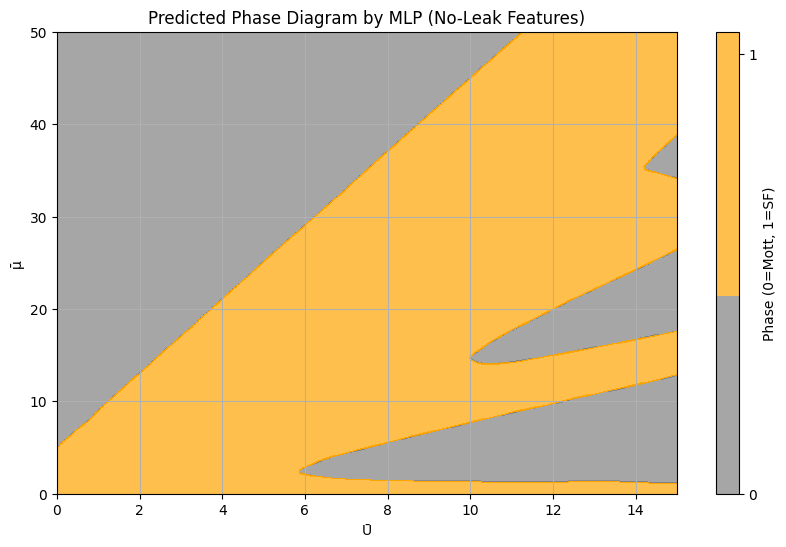

Example: Ū=10.5, μ̄=15.2  → Mott Insulator
Example: Ū=18.0, μ̄=40.0  → Mott Insulator

📊 Classification Report (Model vs True on full dataset domain):
              precision    recall  f1-score   support

           0     0.9982    0.9949    0.9965     34816
           1     0.9957    0.9984    0.9971     40835

    accuracy                         0.9968     75651
   macro avg     0.9969    0.9967    0.9968     75651
weighted avg     0.9968    0.9968    0.9968     75651



In [9]:
# -----------------------------
# 6) Predict and plot phase diagram on a grid
# You can change U_max / mu_max to extrapolate beyond training range, but be cautious:
# ML extrapolation is inherently uncertain.
# -----------------------------
U_min, U_max = 0.0, 15.0  # extend beyond training (train is up to ~15)
mu_min, mu_max = 0.0, 50.0
U_step, mu_step = 0.01, 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_df = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})
grid_features = add_features(grid_df)

grid_pred = best_clf.predict(grid_features)  # predicted phase
grid_map = grid_pred.reshape(U_grid.shape)

plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, grid_map,
             cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title(f"Predicted Phase Diagram by {best_name} (No-Leak Features)")
plt.grid(True)
plt.show()

# -----------------------------
# 7) Helper to predict at a point (Ubar, Mubar)
# -----------------------------
def predict_phase(model, Ubar, Mubar):
    pt = pd.DataFrame({"Ubar": [Ubar], "Mubar": [Mubar]})
    pt_feat = add_features(pt)
    pred = model.predict(pt_feat)[0]
    return "Superfluid" if pred == 1 else "Mott Insulator"

# Example prediction:
print("Example:",  "Ū=10.5, μ̄=15.2  →", predict_phase(best_clf, 10.5, 15.2))
print("Example:",  "Ū=18.0, μ̄=40.0  →", predict_phase(best_clf, 18.0, 40.0))

# -----------------------------
# 8) In-range validation: compare model predictions with TRUE labels (same domain)
#    This checks how well we approximate the physics solver inside the training domain.
# -----------------------------
X_true = add_features(df[["Ubar", "Mubar"]])
y_true = df["Phase"].values
y_pred_true = best_clf.predict(X_true)

print("\n📊 Classification Report (Model vs True on full dataset domain):")
print(classification_report(y_true, y_pred_true, digits=4))

# All Regression Models and MLP ( final check with different additional models)
models = {
       
    "LogReg-Poly2": logreg_poly2,  
    "SVM-RBF": svm_rbf,
    "RF-Shallow": rf_shallow,
    "RandomForest": rf,
    "MLP": mlp,
    "SVM": svm
}
6 models

## Logistic Regression 
with low-degree polynomial features 
(smooth boundary)
## SVM with RBF kernel
(smooth boundary, good generalization with proper C/gamma)
## RandomForest shallow 
(to avoid overfitting)
## rf 
= RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
## mlp 
= Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])
## svm 
= Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="poly", degree=3, C=1.0))
    ])



📊 Classification Report for LogReg-Poly2:
              precision    recall  f1-score   support

           0     0.9317    0.8559    0.8922      8704
           1     0.8851    0.9465    0.9148     10209

    accuracy                         0.9048     18913
   macro avg     0.9084    0.9012    0.9035     18913
weighted avg     0.9066    0.9048    0.9044     18913


📊 Classification Report for SVM-RBF:
              precision    recall  f1-score   support

           0     0.9192    0.9643    0.9412      8704
           1     0.9682    0.9277    0.9475     10209

    accuracy                         0.9445     18913
   macro avg     0.9437    0.9460    0.9444     18913
weighted avg     0.9456    0.9445    0.9446     18913


📊 Classification Report for RF-Shallow:
              precision    recall  f1-score   support

           0     0.9949    0.9862    0.9905      8704
           1     0.9883    0.9957    0.9920     10209

    accuracy                         0.9913     18913
   mac

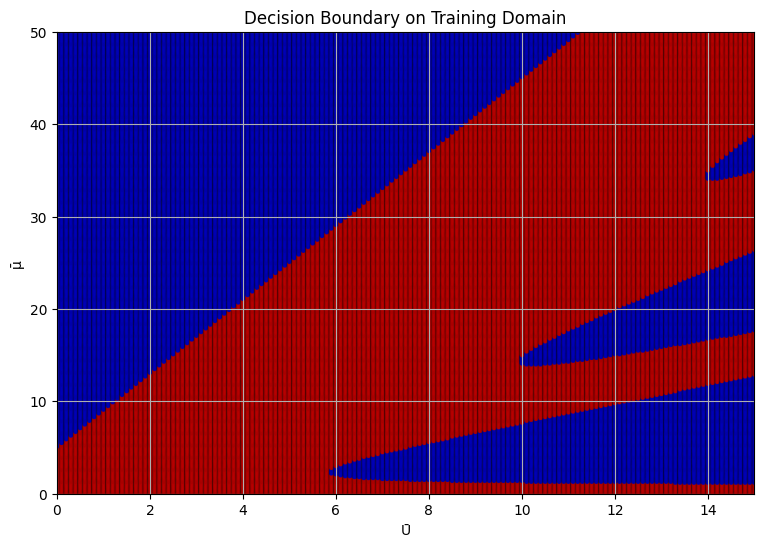

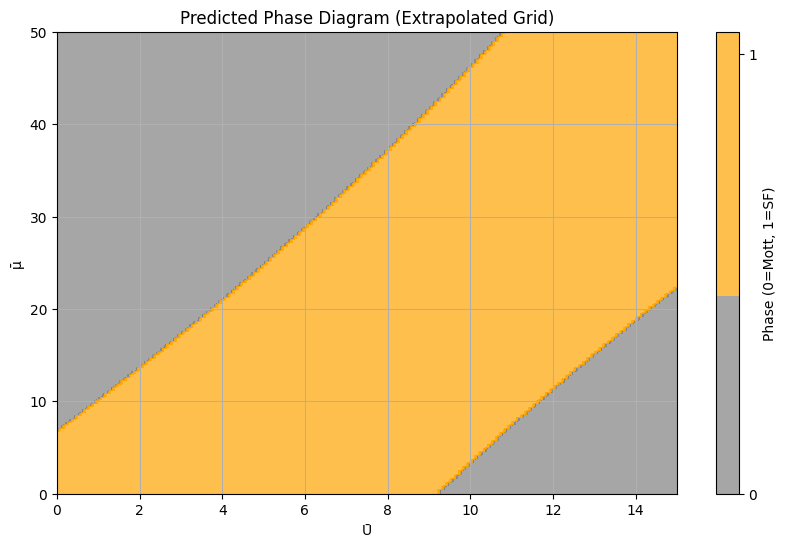


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9324    0.8554    0.8923     34816
           1     0.8848    0.9472    0.9149     40835

    accuracy                         0.9049     75651
   macro avg     0.9086    0.9013    0.9036     75651
weighted avg     0.9067    0.9049    0.9045     75651



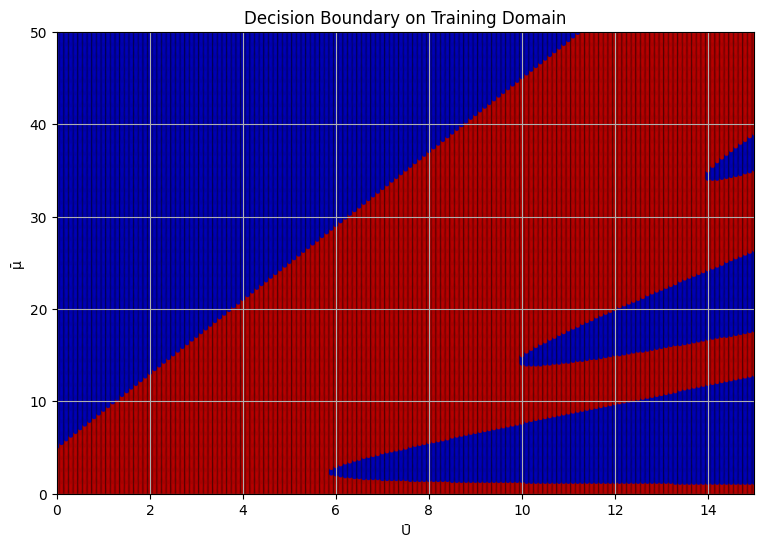

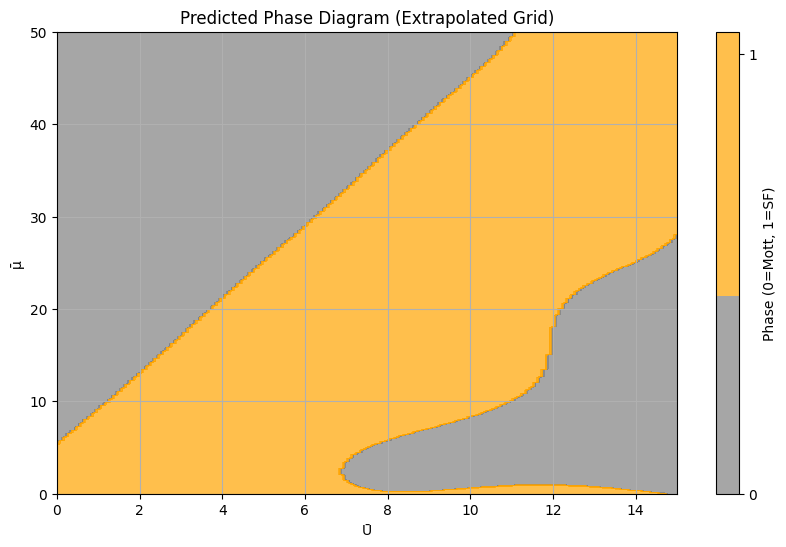


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9226    0.9638    0.9428     34816
           1     0.9679    0.9311    0.9491     40835

    accuracy                         0.9461     75651
   macro avg     0.9453    0.9474    0.9459     75651
weighted avg     0.9471    0.9461    0.9462     75651



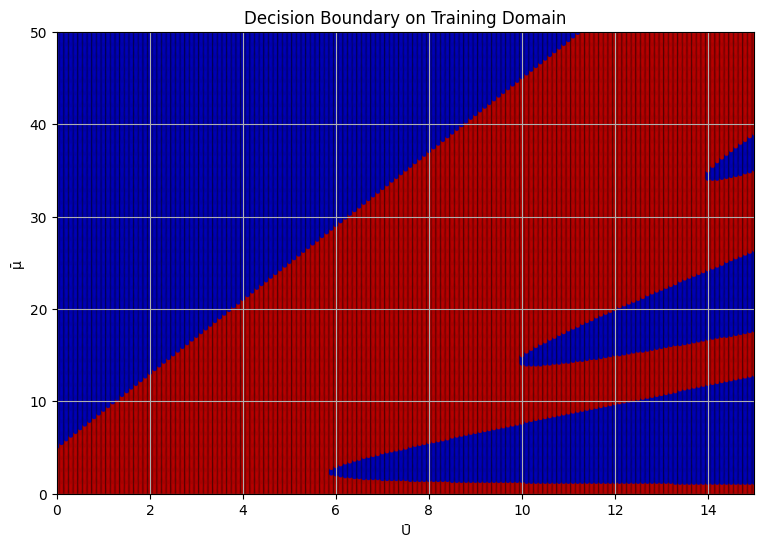

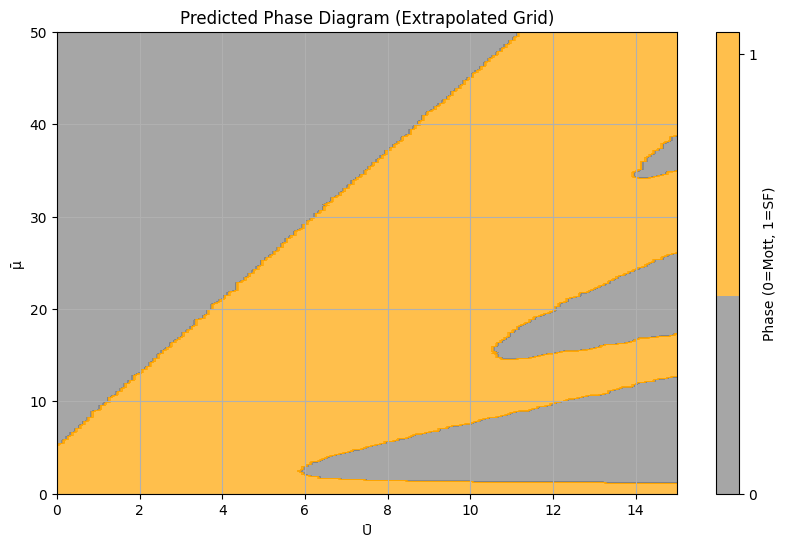


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9976    0.9908    0.9942     34816
           1     0.9922    0.9980    0.9951     40835

    accuracy                         0.9947     75651
   macro avg     0.9949    0.9944    0.9946     75651
weighted avg     0.9947    0.9947    0.9947     75651



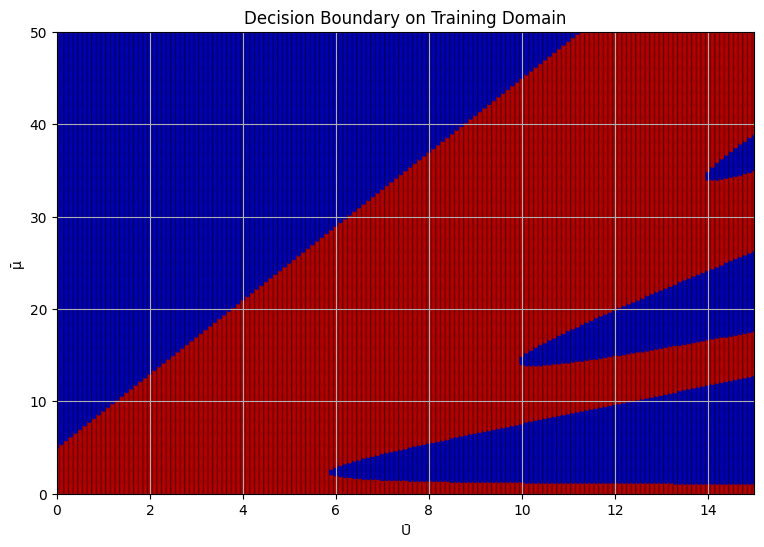

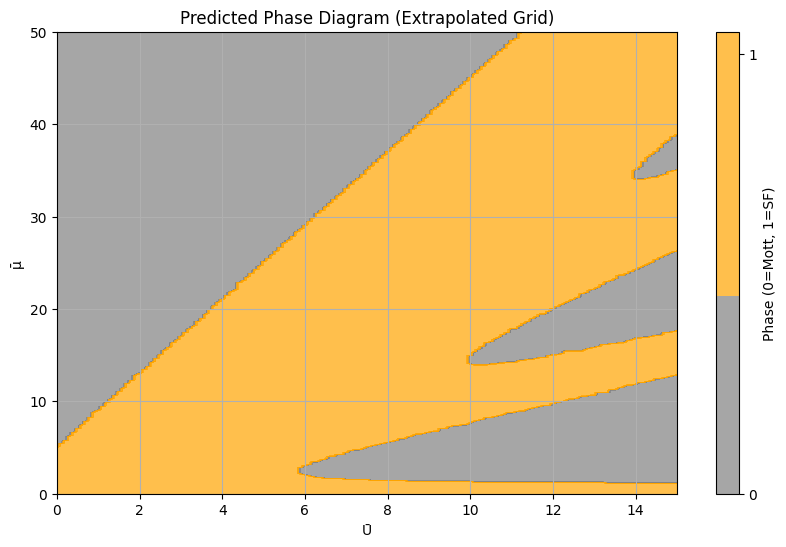


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9983    0.9988    0.9985     34816
           1     0.9989    0.9986    0.9988     40835

    accuracy                         0.9987     75651
   macro avg     0.9986    0.9987    0.9986     75651
weighted avg     0.9987    0.9987    0.9987     75651



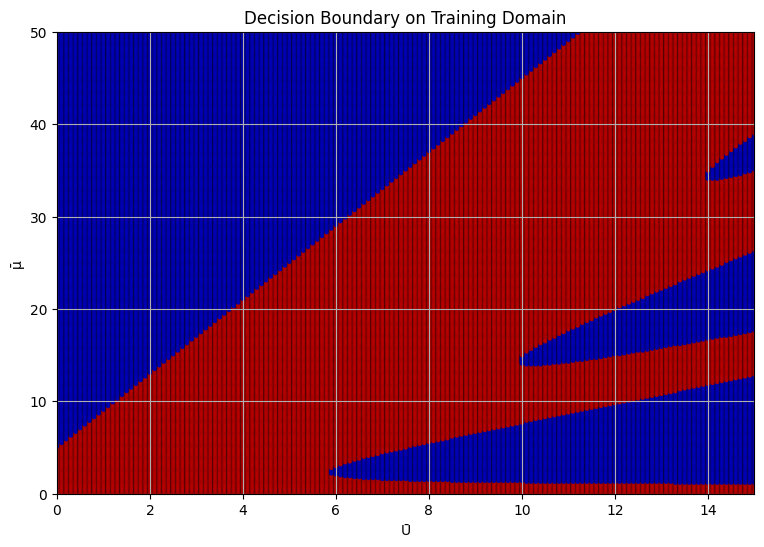

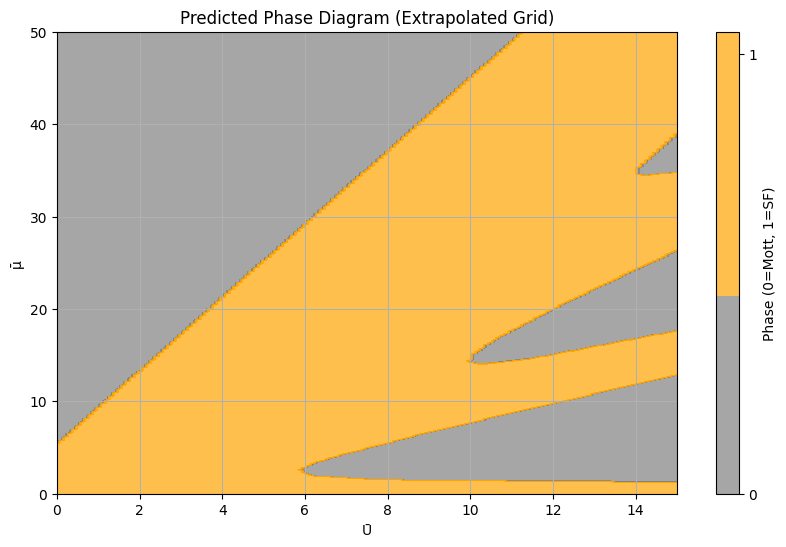


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



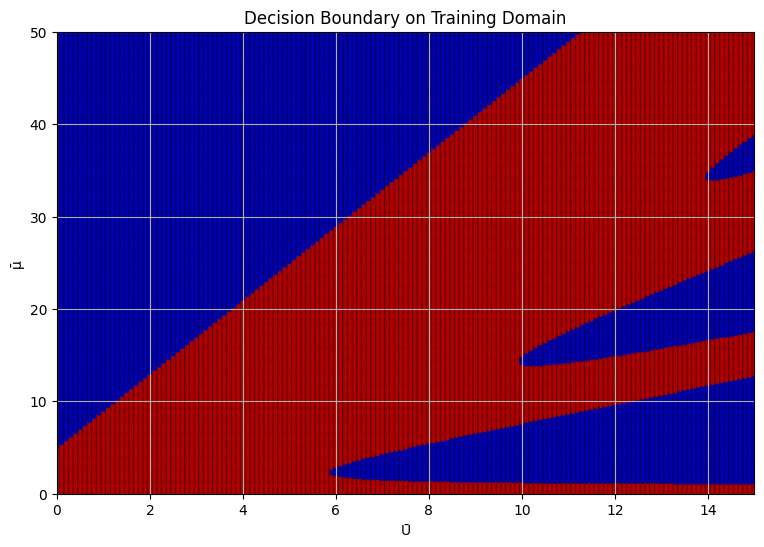

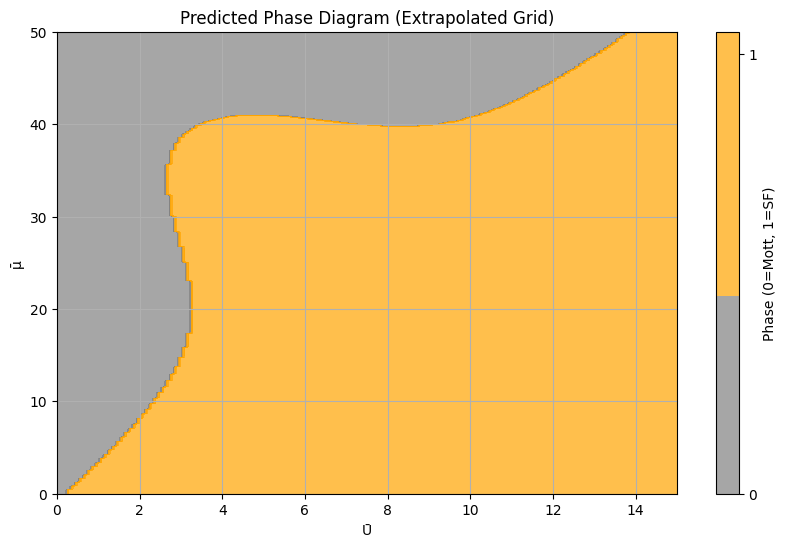


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.8389    0.5371    0.6549     34816
           1     0.6979    0.9120    0.7908     40835

    accuracy                         0.7395     75651
   macro avg     0.7684    0.7245    0.7228     75651
weighted avg     0.7628    0.7395    0.7282     75651



In [15]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
logreg_poly2 = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
])

# (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
svm_rbf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
])

# (C) RandomForest shallow (to avoid overfitting)
rf_shallow = RandomForestClassifier(
    n_estimators=300, max_depth=10, min_samples_leaf=5,
    random_state=42, n_jobs=-1
)

rf = RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

svm = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="poly", degree=3, C=1.0))
    ])
models = {
    "LogReg-Poly2": logreg_poly2,
    "SVM-RBF": svm_rbf,
    "RF-Shallow": rf_shallow,
    "RandomForest": rf,
    "MLP": mlp,
    "SVM": svm
}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))


for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    # ---------- 4) Plot decision boundary on training domain ----------
    def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
        x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
        y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_res),
            np.linspace(y_min, y_max, grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z = model.predict(grid_df).reshape(xx.shape)
    
        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
        plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        plt.show()
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 15.0   # extend beyond training range
    mu_min, mu_max = 0.0, 50.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ",clf)
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model" %i,i "(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


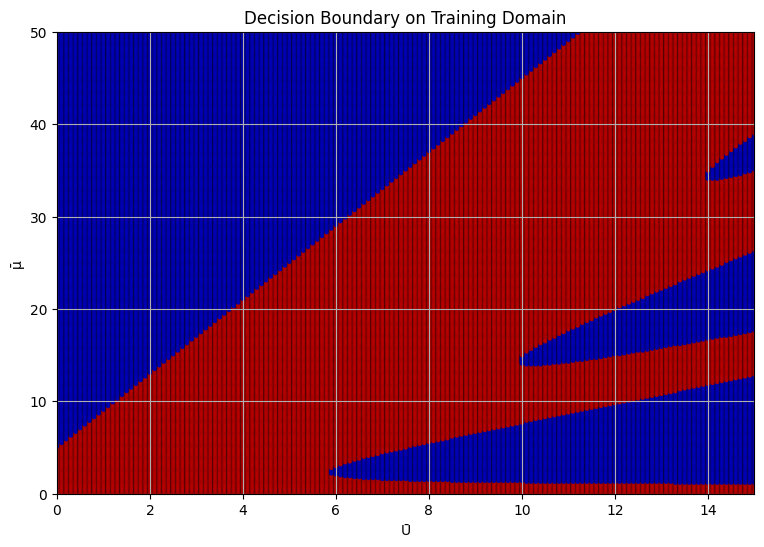

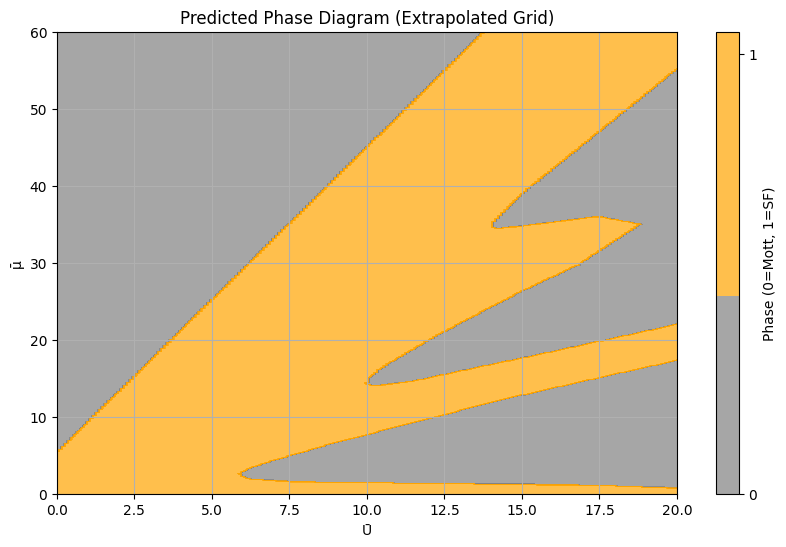


📊 Classification Report (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



In [17]:
clf = models["MLP"]  # or "LogReg-Poly2" or "RF-Shallow"

# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")

# ---------- 5) Predict on an extended grid (extrapolation) ----------
U_min, U_max = 0.0, 20.0   # extend beyond training range
mu_min, mu_max = 0.0, 60.0
U_step, mu_step = 0.1, 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_ext = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

pred_ext = clf.predict(grid_ext)
phase_map = pred_ext.reshape(U_grid.shape)

plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Phase Diagram (Extrapolated Grid)")
plt.grid(True)
plt.show()

# ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
# Only compare inside the original data domain (U≤15, μ≤50)
mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
grid_in_domain = grid_ext[mask_domain].copy()
pred_in_domain = clf.predict(grid_in_domain)

# Build true labels by nearest neighbor lookup on your dataset (coarse but works)
# Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
df_lookup = df.copy()
df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]

grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values

# Drop NaNs (grid points that don't map exactly to a dataset point)
valid = ~pd.isna(true_labels)
true_labels = true_labels[valid].astype(int)
pred_labels = pred_in_domain[valid]

print("\n📊 Classification Report (Extrapolated Grid vs True, within data domain):")
print(classification_report(true_labels, pred_labels, digits=4))


# Keras NN, MLP, MLP Tuned 


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9992    0.9884    0.9938      8704
           1     0.9902    0.9993    0.9947     10209

    accuracy                         0.9943     18913
   macro avg     0.9947    0.9939    0.9942     18913
weighted avg     0.9943    0.9943    0.9943     18913


📊 Classification Report for MLP-Tuned:
              precision    recall  f1-score   support

           0     0.9899    0.9937    0.9918      8704
           1     0.9946    0.9914    0.9930     10209

    accuracy                         0.9924     18913
   macro avg     0.9923    0.9925    0.9924     18913
weighted avg     0.9924    0.9924    0.9924     18913


📊 Classification Report for Keras-NN:
              precision    recall  f1-score   support

           0     0.9978    0.9782    0.9879      8704
           1     0.9817    0.9981    0.9898     10209

    accuracy                         0.9889     18913
   macro avg   

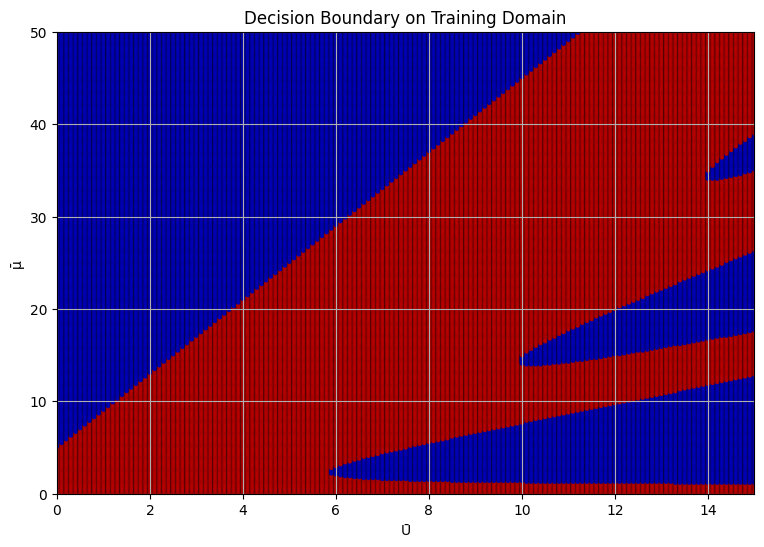

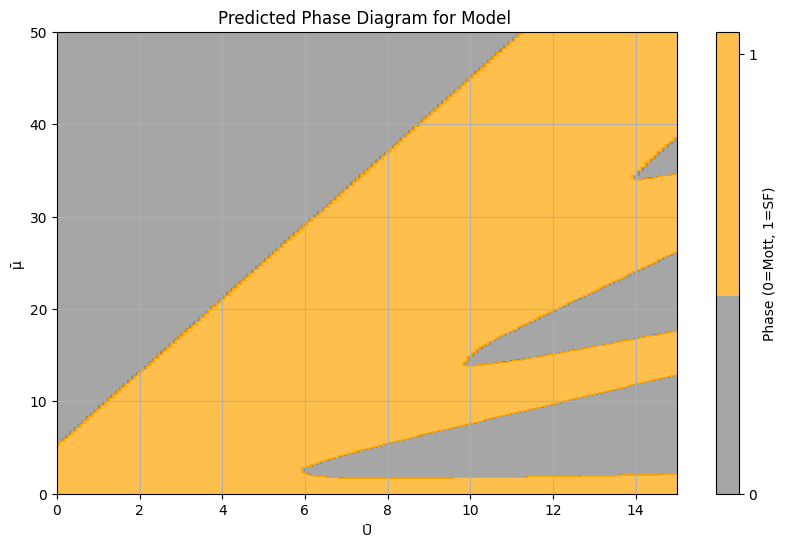


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9979    0.9788    0.9883     34816
           1     0.9822    0.9982    0.9902     40835

    accuracy                         0.9893     75651
   macro avg     0.9901    0.9885    0.9892     75651
weighted avg     0.9894    0.9893    0.9893     75651



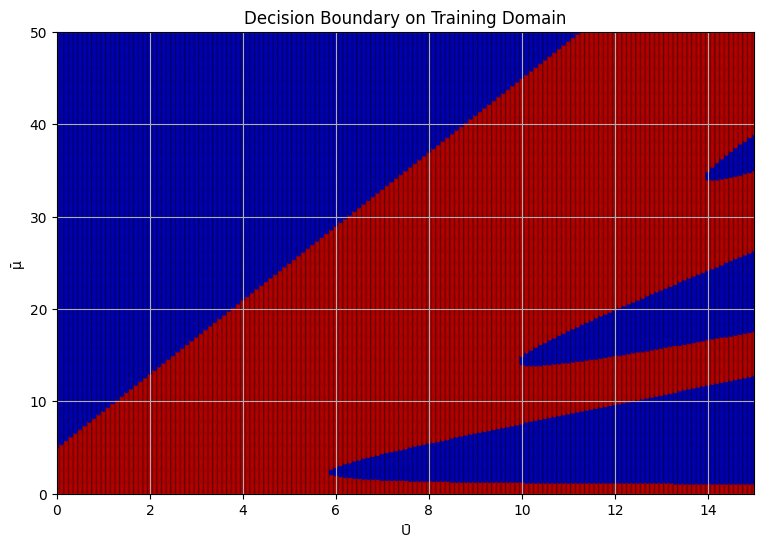

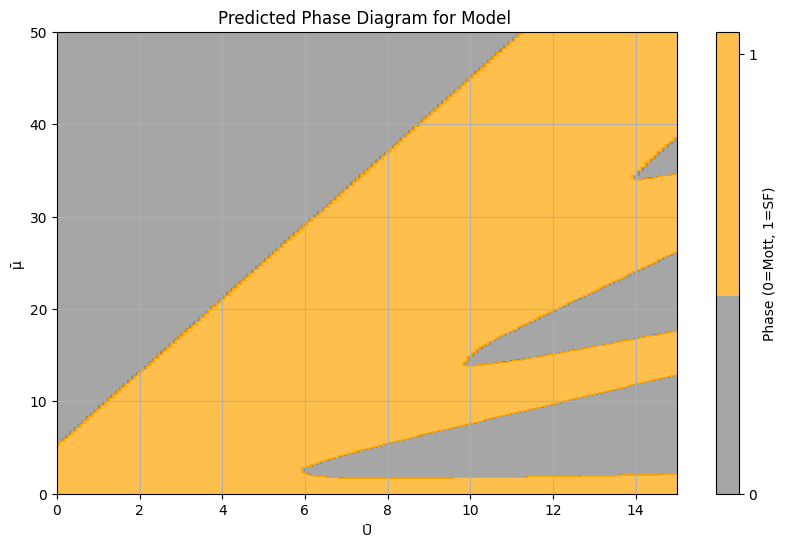


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9979    0.9788    0.9883     34816
           1     0.9822    0.9982    0.9902     40835

    accuracy                         0.9893     75651
   macro avg     0.9901    0.9885    0.9892     75651
weighted avg     0.9894    0.9893    0.9893     75651



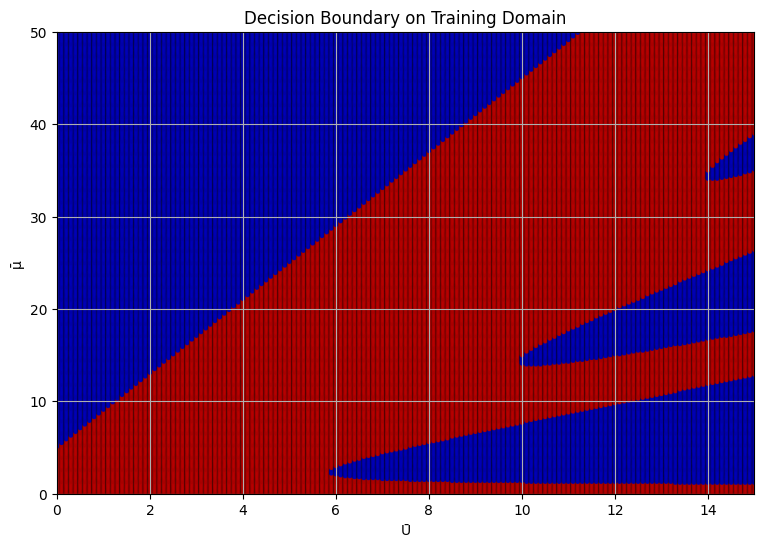

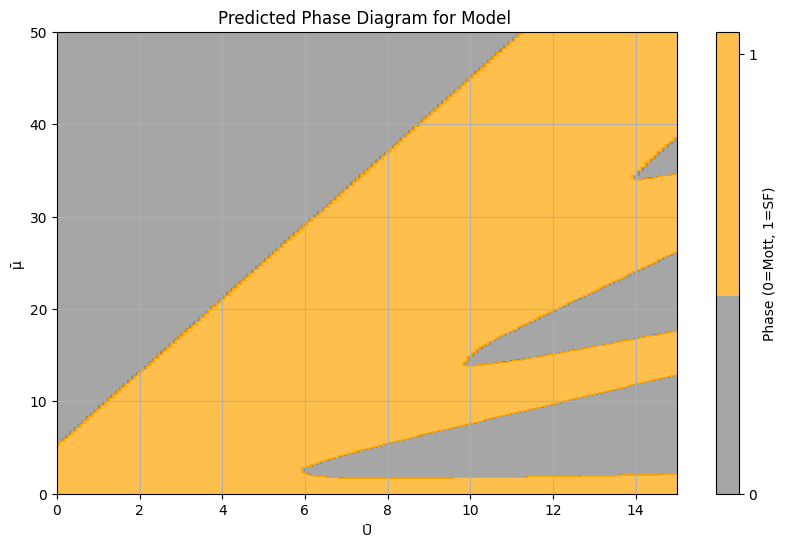


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9979    0.9788    0.9883     34816
           1     0.9822    0.9982    0.9902     40835

    accuracy                         0.9893     75651
   macro avg     0.9901    0.9885    0.9892     75651
weighted avg     0.9894    0.9893    0.9893     75651



In [33]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# --- Tuned MLP ---
mlp_tuned = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(hidden_layer_sizes=(200, 200, 100),
                          activation='relu',
                          solver='adam',
                          alpha=1e-4,
                          learning_rate_init=1e-3,
                          max_iter=2000,
                          random_state=42))
])

# --- Keras Sequential NN ---
def create_keras_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# --- Manual Keras NN wrapper ---
class KerasNNWrapper:
    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        self.model = keras.Sequential([
            keras.layers.Input(shape=(2,)),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(128, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        self.model.fit(X_scaled, y, epochs=50, batch_size=32, verbose=0)
        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        preds = self.model.predict(X_scaled, verbose=0)
        return (preds > 0.5).astype(int).ravel()

keras_nn = KerasNNWrapper()

# --- TabNet (optional, needs pip install pytorch-tabnet) ---
tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp,
    "MLP-Tuned": mlp_tuned,
    "Keras-NN": keras_nn,
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    # Z = model.predict(grid_df).reshape(xx.shape)
    if name == "TabNet":
        Z = model.predict(grid_df.values).reshape(xx.shape)
    else:
        Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 15.0   # extend beyond training range
    mu_min, mu_max = 0.0, 50.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    # pred_ext = clf.predict(grid_ext)
    if name == "TabNet":
        pred_ext = model.predict(grid_ext.values)
    else:
        pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    # pred_in_domain = clf.predict(grid_in_domain)
      
    if name == "TabNet":
        pred_in_domain = model.predict(grid_in_domain.values)
    else:
        pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


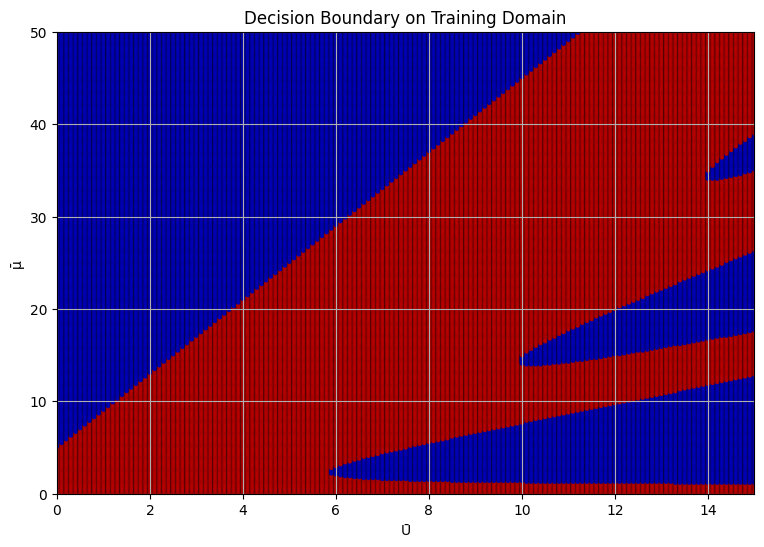

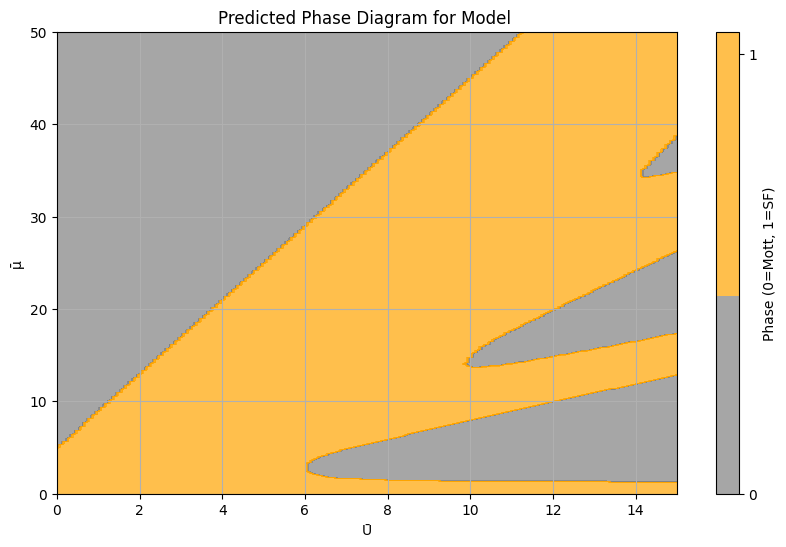


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9876    0.9932    0.9904     34816
           1     0.9942    0.9894    0.9918     40835

    accuracy                         0.9912     75651
   macro avg     0.9909    0.9913    0.9911     75651
weighted avg     0.9912    0.9912    0.9912     75651



In [29]:
clf = models["MLP"]  # or "LogReg-Poly2" or "RF-Shallow"

plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")

# ---------- 5) Predict on an extended grid (extrapolation) ----------
U_min, U_max = 0.0, 15.0   # extend beyond training range
mu_min, mu_max = 0.0, 50.0
U_step, mu_step = 0.1, 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_ext = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

# pred_ext = clf.predict(grid_ext)
if name == "TabNet":
    pred_ext = model.predict(grid_ext.values)
else:
    pred_ext = model.predict(grid_ext)
phase_map = pred_ext.reshape(U_grid.shape)

plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Phase Diagram for Model ")
plt.grid(True)
plt.show()

# ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
# Only compare inside the original data domain (U≤15, μ≤50)
mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
grid_in_domain = grid_ext[mask_domain].copy()
# pred_in_domain = clf.predict(grid_in_domain)
  
if name == "TabNet":
    pred_in_domain = model.predict(grid_in_domain.values)
else:
    pred_in_domain = model.predict(grid_in_domain)

# Build true labels by nearest neighbor lookup on your dataset (coarse but works)
# Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
df_lookup = df.copy()
df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]

grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values

# Drop NaNs (grid points that don't map exactly to a dataset point)
valid = ~pd.isna(true_labels)
true_labels = true_labels[valid].astype(int)
pred_labels = pred_in_domain[valid]

print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
print(classification_report(true_labels, pred_labels, digits=4))

# Updation of MLP tuned and Keras NN for better Accuracy 


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9992    0.9884    0.9938      8704
           1     0.9902    0.9993    0.9947     10209

    accuracy                         0.9943     18913
   macro avg     0.9947    0.9939    0.9942     18913
weighted avg     0.9943    0.9943    0.9943     18913


📊 Classification Report for MLP-Tuned:
              precision    recall  f1-score   support

           0     0.9976    0.9949    0.9963      8704
           1     0.9957    0.9979    0.9968     10209

    accuracy                         0.9966     18913
   macro avg     0.9966    0.9964    0.9965     18913
weighted avg     0.9966    0.9966    0.9966     18913


📊 Classification Report for Keras-NN:
              precision    recall  f1-score   support

           0     0.9976    0.9985    0.9980      8704
           1     0.9987    0.9979    0.9983     10209

    accuracy                         0.9982     18913
   macro avg   

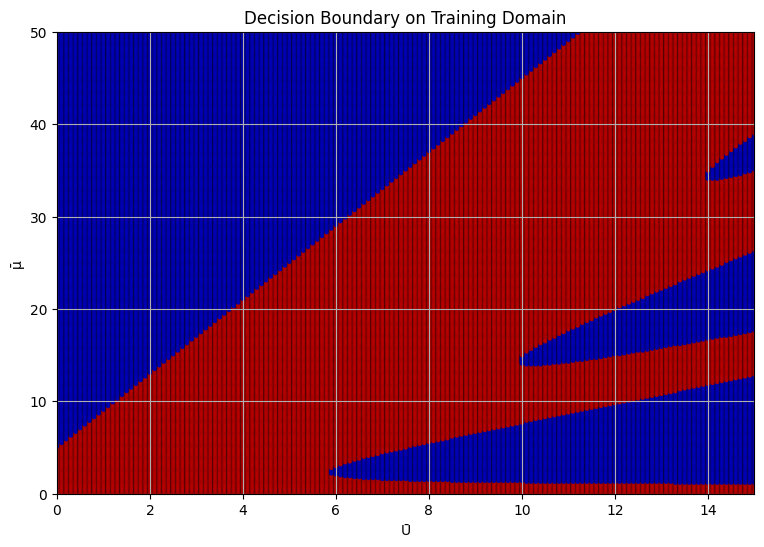

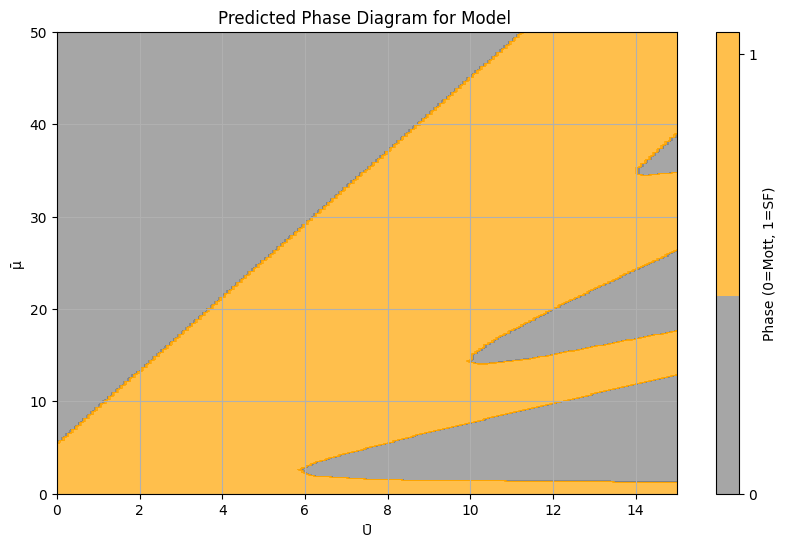


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



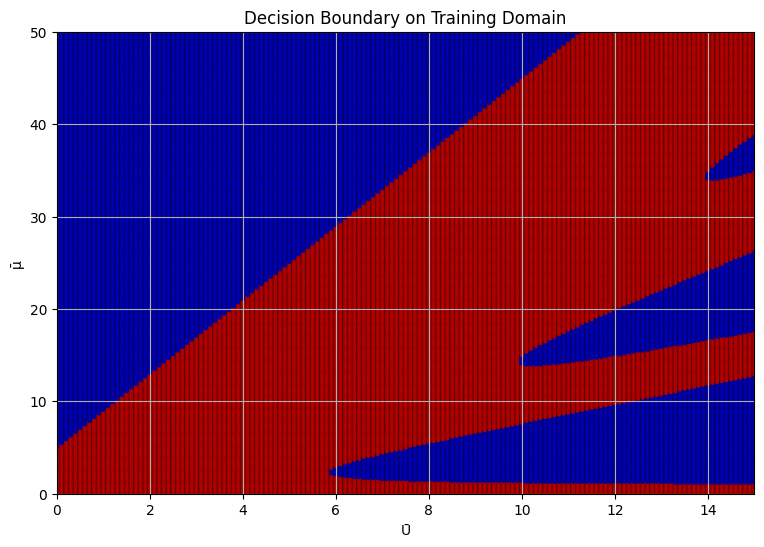

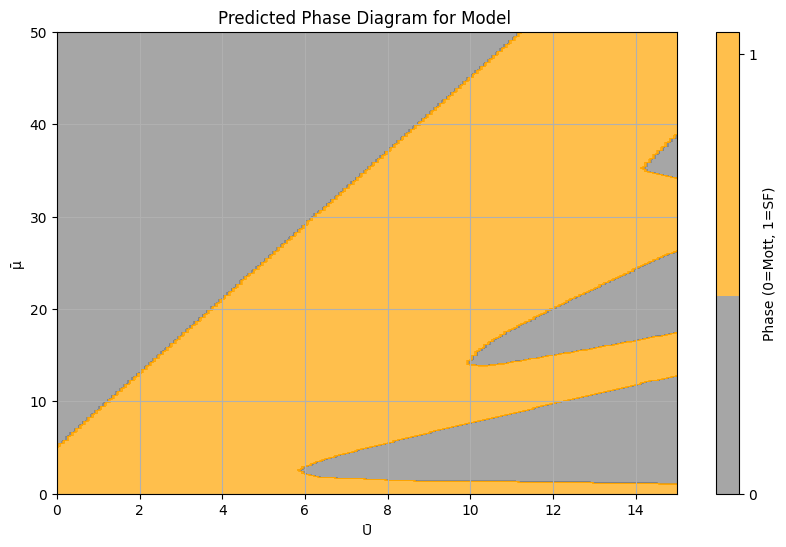


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9975    0.9947    0.9961     34816
           1     0.9955    0.9978    0.9967     40835

    accuracy                         0.9964     75651
   macro avg     0.9965    0.9963    0.9964     75651
weighted avg     0.9964    0.9964    0.9964     75651



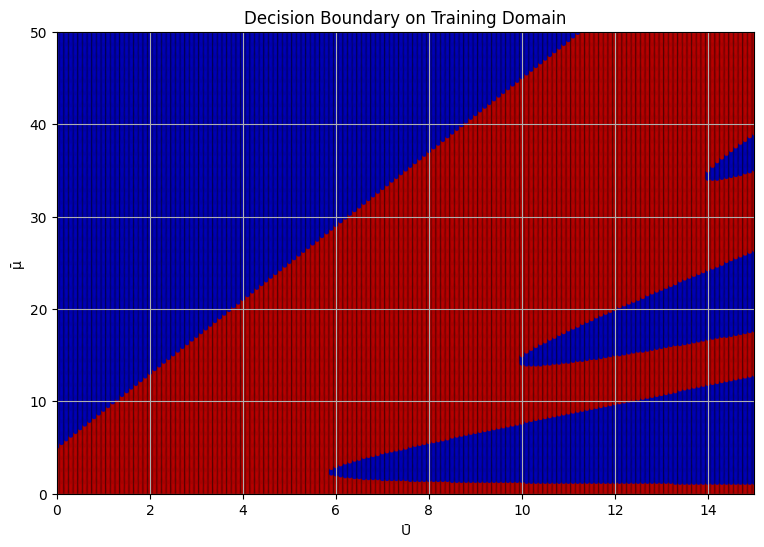

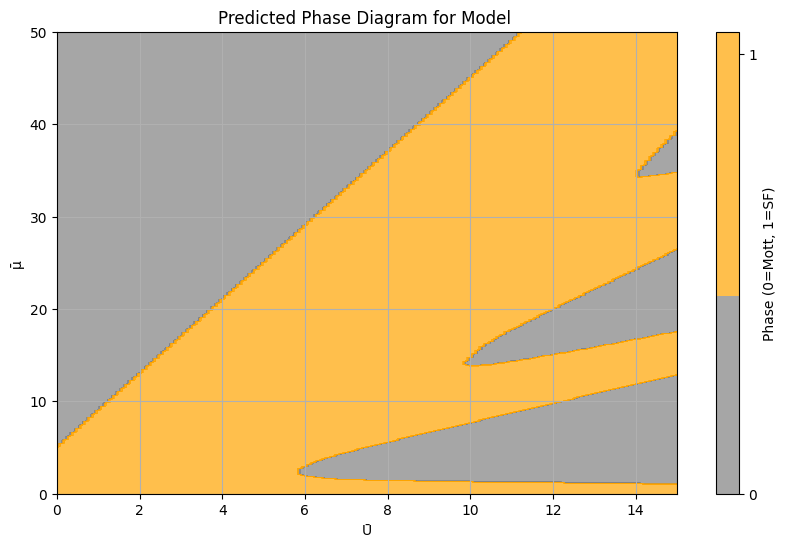


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9978    0.9983    0.9980     34816
           1     0.9986    0.9981    0.9983     40835

    accuracy                         0.9982     75651
   macro avg     0.9982    0.9982    0.9982     75651
weighted avg     0.9982    0.9982    0.9982     75651



In [5]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# Updated MLP (Scikit-learn)
# =========================
mlp_tuned = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,                # L2 regularization
        learning_rate_init=5e-4,   # Lower learning rate
        max_iter=500,
        early_stopping=True,       # built-in in sklearn
        n_iter_no_change=20,
        validation_fraction=0.15,
        random_state=42
    ))
])

# =========================
# Updated Keras Model
# =========================
def create_keras_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(128, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

keras_nn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=create_keras_model,
        epochs=200,
        batch_size=64,
        verbose=0,
        validation_split=0.15,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
        ]
    ))
])

# --- TabNet (optional, needs pip install pytorch-tabnet) ---
tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp,
    "MLP-Tuned": mlp_tuned,
    "Keras-NN": keras_nn
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 15.0   # extend beyond training range
    mu_min, mu_max = 0.0, 50.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


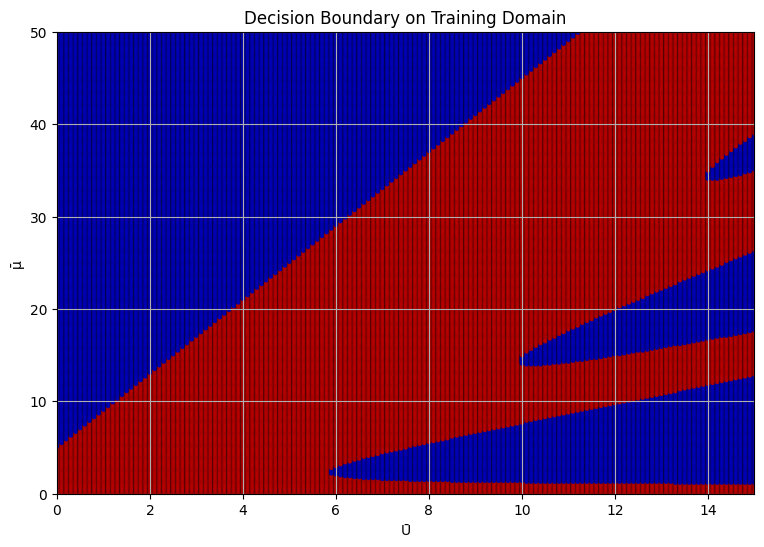

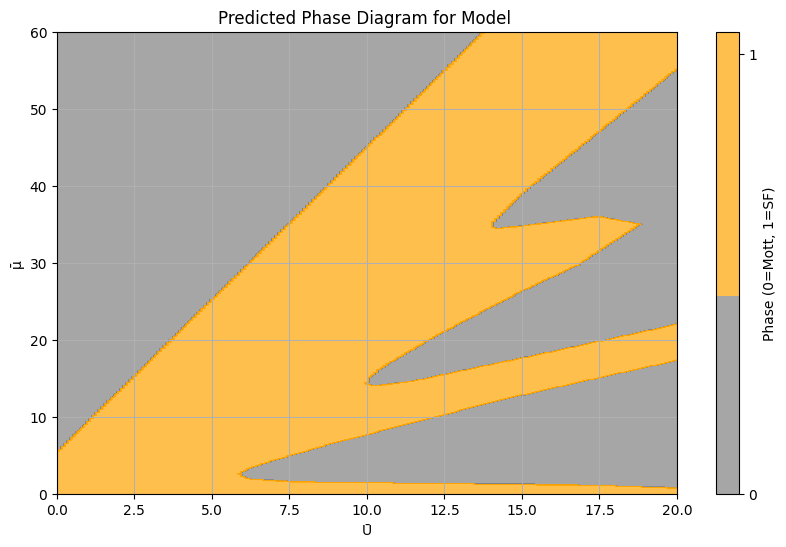


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



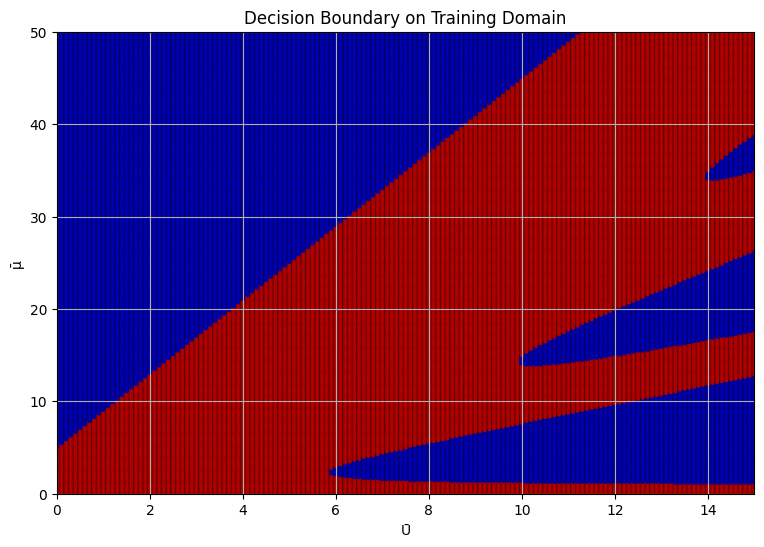

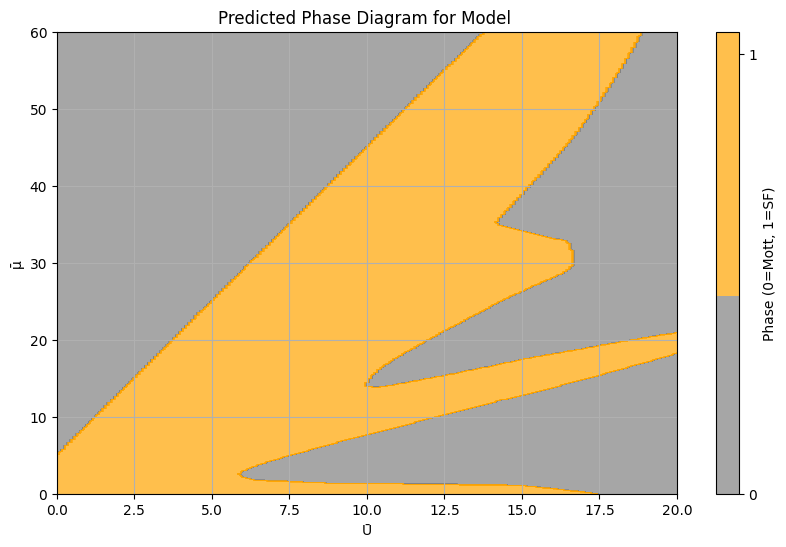


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9975    0.9947    0.9961     34816
           1     0.9955    0.9978    0.9967     40835

    accuracy                         0.9964     75651
   macro avg     0.9965    0.9963    0.9964     75651
weighted avg     0.9964    0.9964    0.9964     75651



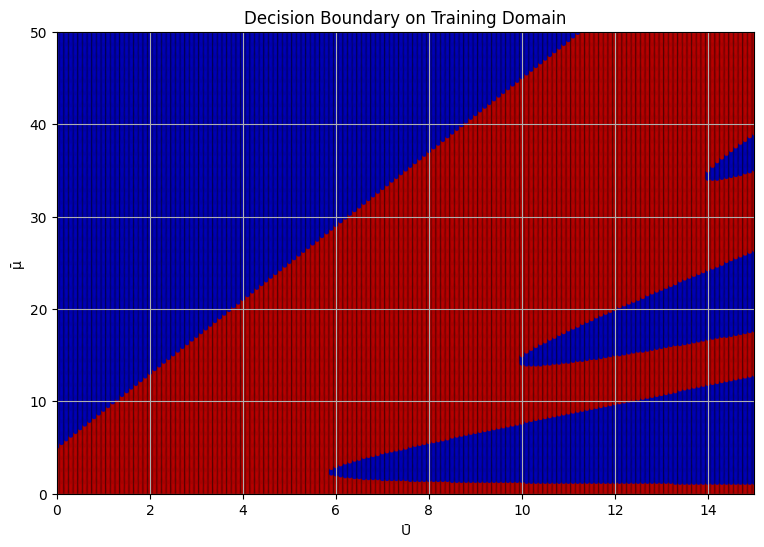

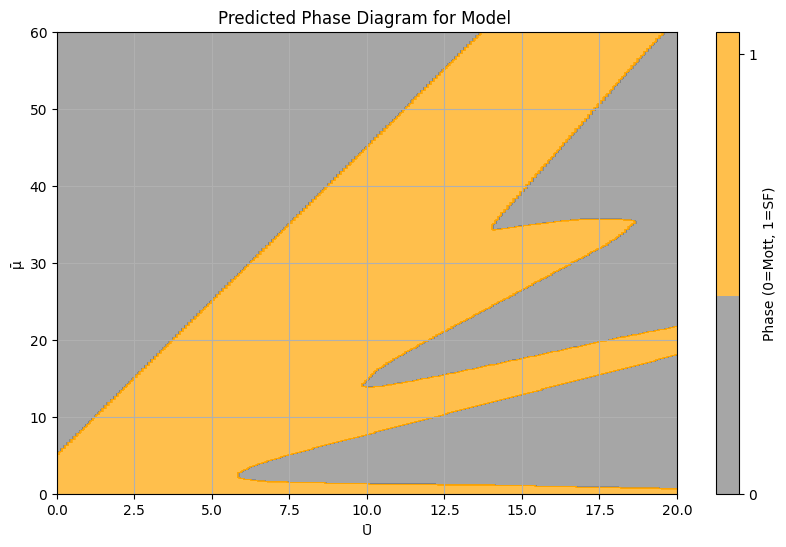


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9978    0.9983    0.9980     34816
           1     0.9986    0.9981    0.9983     40835

    accuracy                         0.9982     75651
   macro avg     0.9982    0.9982    0.9982     75651
weighted avg     0.9982    0.9982    0.9982     75651



In [6]:
for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 20.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

**In the before update Keras NN comes out top on both training and prediction**

**Observations**

- On the training data domain predictions (not extrapolation):

- Keras-NN is now top: 0.9982 accuracy, with perfectly balanced precision/recall for both classes.

- MLP-Tuned is slightly behind at 0.9964.

- Plain MLP is still solid at 0.9946 but clearly worse than the tuned variants.

**Why this is interesting:**

- Keras is doing better both in the classification report and in smoothing out the Mott lobe edges — meaning the regularization + dropout + early stopping combo is working.

- MLP-Tuned in sklearn improved a lot compared to your original, but still doesn’t quite match Keras’s smoothness — likely because sklearn’s MLP implementation doesn’t offer the same fine-grained regularization and callback control.

**The “pointy lobe” issue:**

- For MLP-Tuned, there’s still a slight overfitting to the training domain, causing the sharp corners near g=3 in your phase diagram.

- Keras, with dropout + lower LR + patience-based LR scheduling, seems to be smoothing these out better.


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9992    0.9884    0.9938      8704
           1     0.9902    0.9993    0.9947     10209

    accuracy                         0.9943     18913
   macro avg     0.9947    0.9939    0.9942     18913
weighted avg     0.9943    0.9943    0.9943     18913


📊 Classification Report for MLP-Tuned:
              precision    recall  f1-score   support

           0     0.9976    0.9949    0.9963      8704
           1     0.9957    0.9979    0.9968     10209

    accuracy                         0.9966     18913
   macro avg     0.9966    0.9964    0.9965     18913
weighted avg     0.9966    0.9966    0.9966     18913


📊 Classification Report for Keras-NN:
              precision    recall  f1-score   support

           0     0.9970    0.9986    0.9978      8704
           1     0.9988    0.9975    0.9981     10209

    accuracy                         0.9980     18913
   macro avg   

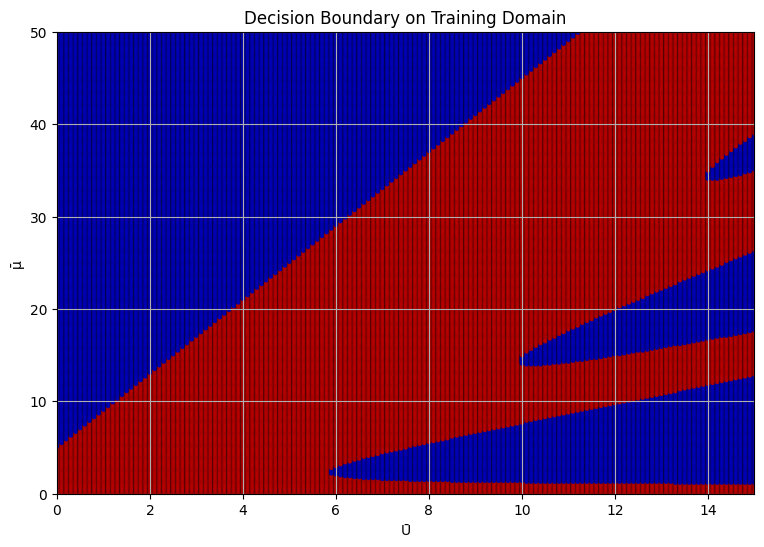

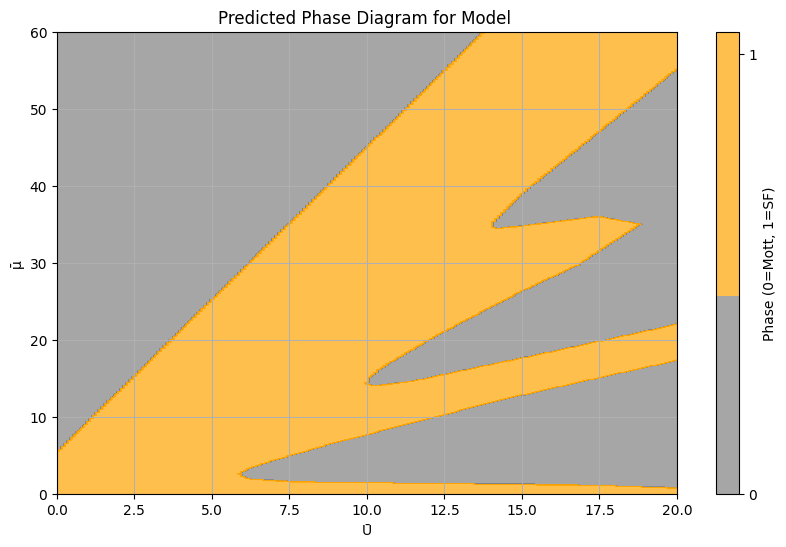


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9995    0.9888    0.9941     34816
           1     0.9905    0.9996    0.9950     40835

    accuracy                         0.9946     75651
   macro avg     0.9950    0.9942    0.9946     75651
weighted avg     0.9947    0.9946    0.9946     75651



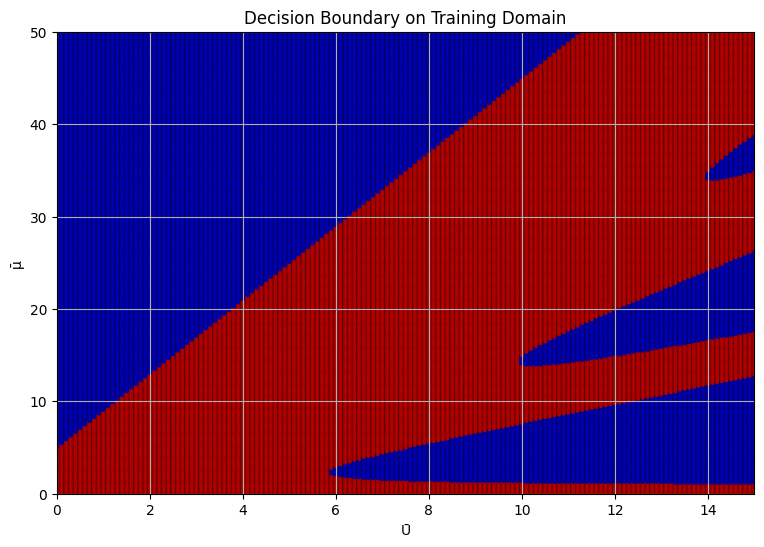

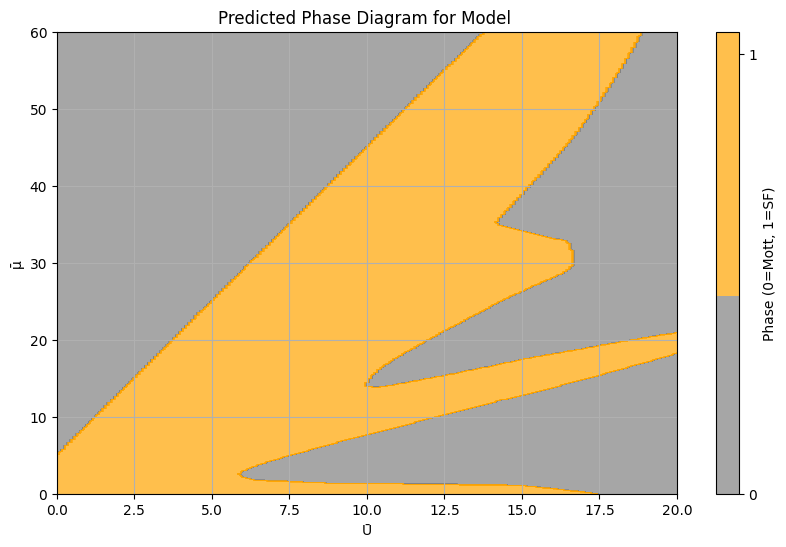


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9975    0.9947    0.9961     34816
           1     0.9955    0.9978    0.9967     40835

    accuracy                         0.9964     75651
   macro avg     0.9965    0.9963    0.9964     75651
weighted avg     0.9964    0.9964    0.9964     75651



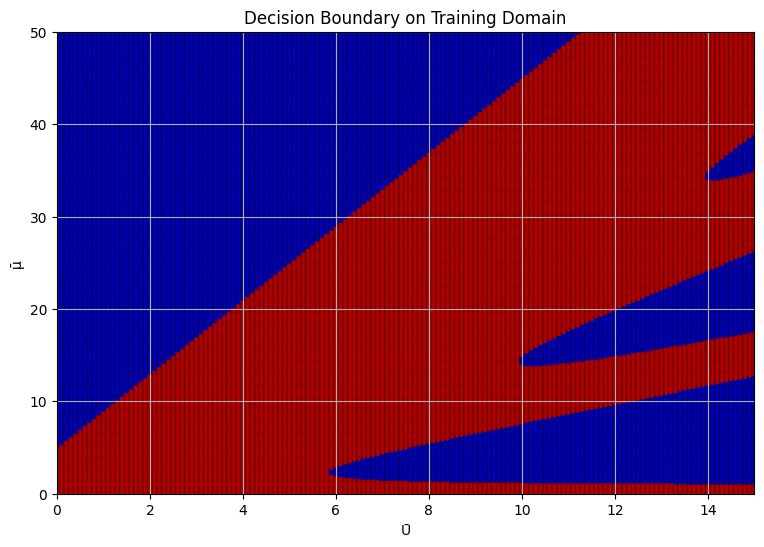

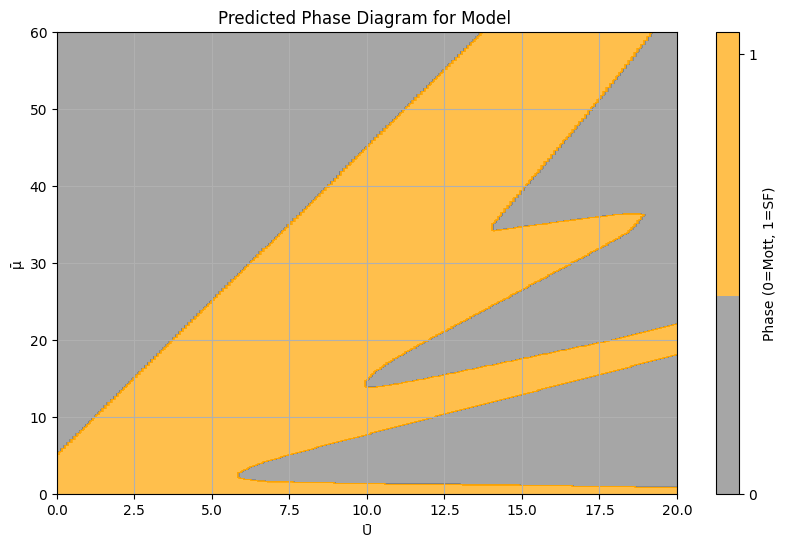


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9972    0.9984    0.9978     34816
           1     0.9987    0.9976    0.9982     40835

    accuracy                         0.9980     75651
   macro avg     0.9979    0.9980    0.9980     75651
weighted avg     0.9980    0.9980    0.9980     75651



In [7]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# Updated MLP (Scikit-learn)
# =========================
mlp_tuned = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,                # L2 regularization
        learning_rate_init=5e-4,   # Lower learning rate
        max_iter=500,
        early_stopping=True,       # built-in in sklearn
        n_iter_no_change=20,
        validation_fraction=0.15,
        random_state=42
    ))
])

# =========================
# Updated Keras Model
# =========================
def create_keras_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(128, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

keras_nn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=create_keras_model,
        epochs=200,
        batch_size=64,
        verbose=0,
        validation_split=0.15,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
        ]
    ))
])

# --- TabNet (optional, needs pip install pytorch-tabnet) ---
tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp,
    "MLP-Tuned": mlp_tuned,
    "Keras-NN": keras_nn
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 20.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


# Keras NN plus method 


📊 Classification Report for Keras-NN-Plus:
              precision    recall  f1-score   support

           0     0.9936    0.9976    0.9956      8704
           1     0.9979    0.9945    0.9962     10209

    accuracy                         0.9959     18913
   macro avg     0.9958    0.9961    0.9959     18913
weighted avg     0.9959    0.9959    0.9959     18913



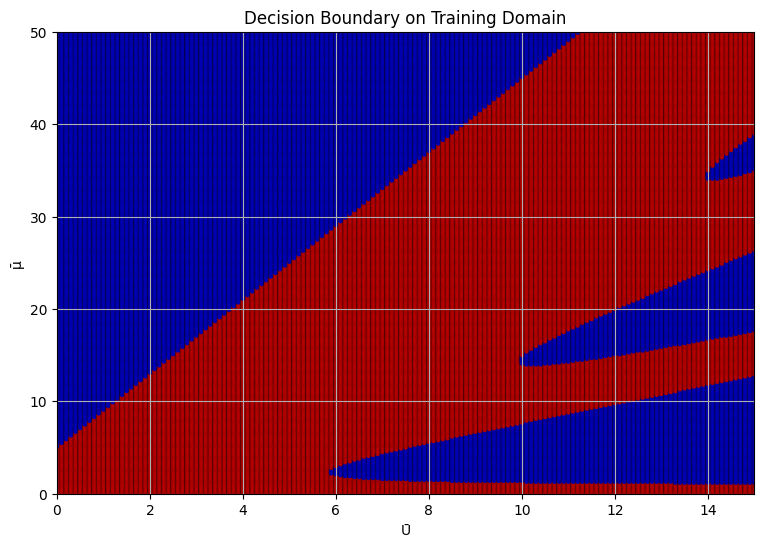

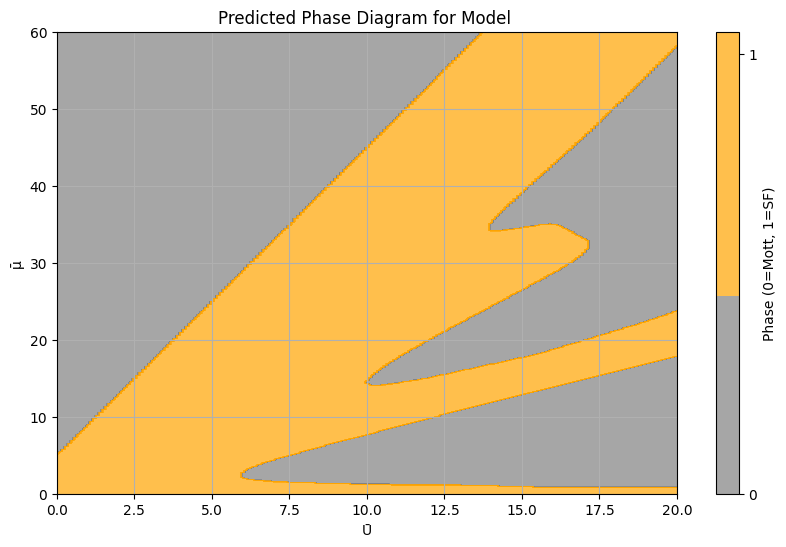


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9936    0.9974    0.9955     34816
           1     0.9977    0.9945    0.9961     40835

    accuracy                         0.9958     75651
   macro avg     0.9957    0.9959    0.9958     75651
weighted avg     0.9958    0.9958    0.9958     75651



In [3]:
# --- imports (add these near your other imports) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from scikeras.wrappers import KerasClassifier


# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# --- improved model builder ---
def build_keras_strong(hidden=(256, 256, 128), dropout=0.05, l2=1e-5, lr=2e-3):
    reg = regularizers.l2(l2)
    inputs = keras.Input(shape=(2,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation='relu', kernel_regularizer=reg)(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

keras_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-5)
]

keras_nn_plus = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=build_keras_strong,
        hidden=(512, 256, 128),
        dropout=0.05,
        l2=1e-5,
        lr=2e-3,
        epochs=500,
        batch_size=512,
        verbose=0,
        random_state=42,
        fit__validation_split=0.15,
        fit__callbacks=keras_callbacks
    ))
])




models = {
    "Keras-NN-Plus": keras_nn_plus # <-- new improved model
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 25.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))




📊 Classification Report for Keras-NN-Plus:
              precision    recall  f1-score   support

           0     0.9989    0.9993    0.9991     24363
           1     0.9989    0.9984    0.9986     16488

    accuracy                         0.9989     40851
   macro avg     0.9989    0.9988    0.9989     40851
weighted avg     0.9989    0.9989    0.9989     40851



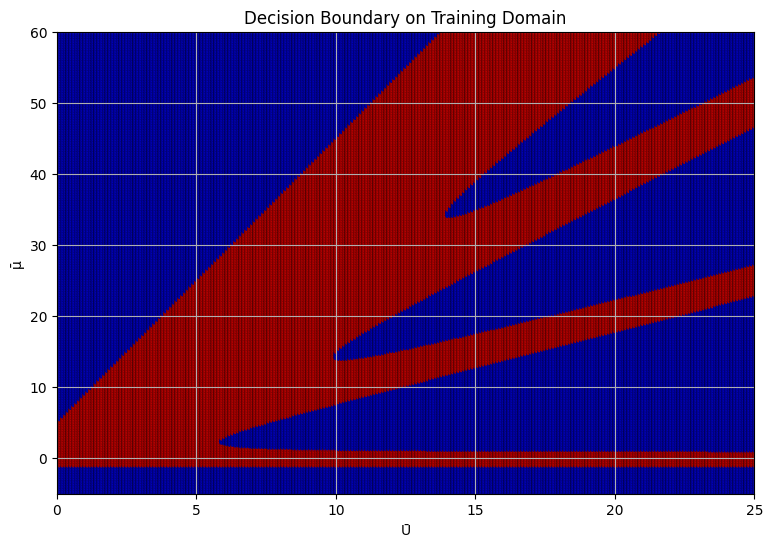

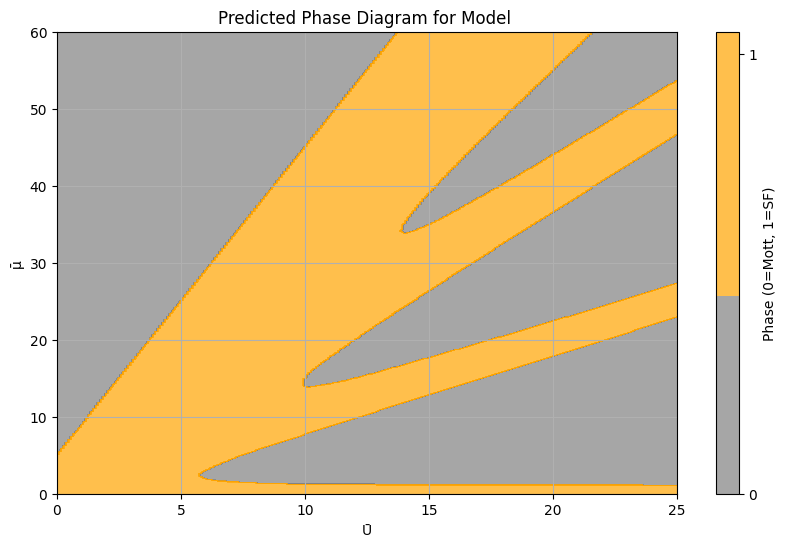


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9990    0.9994    0.9992     87410
           1     0.9992    0.9986    0.9989     63441

    accuracy                         0.9991    150851
   macro avg     0.9991    0.9990    0.9991    150851
weighted avg     0.9991    0.9991    0.9991    150851



In [5]:
# --- imports (add these near your other imports) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from scikeras.wrappers import KerasClassifier


# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# --- improved model builder ---
def build_keras_strong(hidden=(256, 256, 128), dropout=0.05, l2=1e-5, lr=2e-3):
    reg = regularizers.l2(l2)
    inputs = keras.Input(shape=(2,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation='relu', kernel_regularizer=reg)(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)
    opt = keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

keras_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-5)
]

keras_nn_plus = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=build_keras_strong,
        hidden=(512, 256, 128),
        dropout=0.05,
        l2=1e-5,
        lr=2e-3,
        epochs=500,
        batch_size=512,
        verbose=0,
        random_state=42,
        fit__validation_split=0.15,
        fit__callbacks=keras_callbacks
    ))
])




models = {
    "Keras-NN-Plus": keras_nn_plus # <-- new improved model
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(9, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 25.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)

    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

